# First modelling tests 

Some examples found in python 

https://github.com/DP6/Marketing-Attribution-Models

https://victorangeloblancada.github.io/blog/2019/01/01/channel-attribution-in-python.html

https://colab.research.google.com/github/iampatgrady/Simple-Probabalistic-Model-For-Google-Analytics-Users/blob/master/Multitouch_Attribution_Modeling.ipynb#scrollTo=EgwqXCQ3tgM5


In [4]:
# import necessary packages 
import requests
import urllib.parse as up
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import constants_year_MT 
import importlib # to reload the constants module. Necessary if we do changes in module 
import seaborn as sns

In [5]:
# import packages for attribution modelling and graph representation 
import ChannelAttribution
import ChannelAttributionPro as CAP 
password = "gf!AX0!1vbWlF3jXDsm6" # will expire in September
import networkx as nx 

In [6]:
# packages for ML modelling
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix 
from xgboost import plot_importance
from sklearn import metrics 
from collections import Counter
from sklearn.metrics import roc_curve, roc_auc_score

## Import data

* Just 10 features and 1 million rows can be imported at once 
* We had to split table into two (6 months + 6 months) and merge tables afterwards 

In [7]:
# import basic table containing time data 
importlib.reload(constants_year_MT)
from constants_year_MT import url_12months_complete_time_til_june
response_basic_june = requests.get(url_12months_complete_time_til_june)
print(response_basic_june)

# importlib.reload(constants_year_MT)
from constants_year_MT import url_12months_complete_time_til_dec
response_basic_dec = requests.get(url_12months_complete_time_til_dec)
print(response_basic_dec)

<Response [200]>
<Response [200]>


### Create table from url data 

In [8]:
# function to create dataframe from url data 
def url_to_df (url, response): 
    """
    Function to create pandas dataframe from url data. Imported data needs 
    to be of type json or keyjson. Otherwise an exception error is thrown

    Arguments: 
        url: url previously imported from constants file 
        response: previously extracted response 

    Returns: 
        df2: supermetrics information transformed into pandas dataframe 
    """

    if 'data/json?' in url:
        # convert json into pandas df 
        data = json.loads(json.dumps(response.json()))
        df = pd.DataFrame.from_dict(data['data'])
        headers = df.iloc[0]
        df2 = pd.DataFrame(df.values[1:], columns=headers)
    elif 'data/keyjson?' in url:
        # convert json key-value pair output to pandas df 
        df2 = pd.read_json(json.dumps(response.json()))
    else:
        # throw exception message 
        import sys
        sys.exit("DEFINE JSON OR KEYJSON AS OUTPUT FORMAT: https://supermetrics.com/docs/product-api-output-formats/")
    return df2     

In [9]:
df_basic1 = url_to_df(url_12months_complete_time_til_june, response_basic_june)
df_basic2 = url_to_df(url_12months_complete_time_til_dec, response_basic_dec)

# concatenate tables and make copy to work with 
frames = [df_basic1, df_basic2]
df_basic = pd.concat(frames)
df = df_basic

## Data preprocessing 

**The data preparation process was extracted from the EDA file**

* Transform data to correct format 
* Create feature of path order, indicating how many paths exist per clientID. To be used at attribution modelling
* Create feature of new/old client in 2021, using path_order

### Data preprocessing to create `df_eda`

In [10]:
# combine hour + minute 
df['Time'] = (pd.to_datetime(df['Hour'].astype(str) + ':' + df['Minute'].astype(str), format='%H:%M').dt.time)

# drop redundant features 
df.drop('Hour', axis = 1, inplace = True)
df.drop('Minute', axis = 1, inplace = True)

In [11]:
# function to convert data to correct format
def transform_class (df, feats_to_convert):
    for f in feats_to_convert: 
        if f in ['Date', 'Time']:
            df[f] = pd.to_datetime(df[f])
        #elif f == 'Time': 
        #    df[f] = pd.to_datetime(df[f], format='%H:%M:%S')
        else: # all numeric 
            df[f] = pd.to_numeric(df[f], errors = 'coerce')
    return df

feats_to_convert = ['Date', 'Transactions', 'Transaction revenue', 'Pageviews', 'Total time on site', 'Users']
df = transform_class(df, feats_to_convert)

In [12]:
# reorder columns 
df = df[['clientID', 'Date', 'Time', 'Transactions', 'Transaction revenue', 'Channel group', 'Operating system', 'Source', 'Medium', 'Total time on site', 'Pageviews', 'Users']]

# reorder table by clientID, Date and Time 
df = df.sort_values(['clientID', 'Date', 'Time'])

# extract information about first time with total time on site (which can be found on first row) + last time + rename columns 
df_firsttime = df.groupby(['clientID', 'Date', 'Channel group'], as_index = False)['Time'].first()
df_firsttime.rename(columns = {'Time':'time_start'}, inplace = True)
df_lasttime = df.groupby(['clientID', 'Date', 'Channel group'], as_index = False)['Time'].last()
df_lasttime.rename(columns = {'Time':'time_end'}, inplace = True)

# 'outer' keeps both, merge on all feats to avoid redundancy in merged dataset 
df_first_and_last = pd.merge(left = df_firsttime, right = df_lasttime, how = 'outer', on = ['clientID', 'Date', 'Channel group'])
df_first_and_last = df_first_and_last.drop_duplicates() # those where Time (First) and time (last) are the same 
df_first_and_last.head()

# transform date + time into timestamp. Takes a while (~5m)
df_first_and_last['timestamp_start'] = pd.to_datetime(df_first_and_last.Date.apply(str) + ' ' + df_first_and_last.time_start.apply(str))
df_first_and_last['timestamp_end'] = pd.to_datetime(df_first_and_last.Date.apply(str) + ' ' + df_first_and_last.time_end.apply(str))

# calculate difference between both timestamps - in minutes
df_first_and_last['timestamp_diff'] = (df_first_and_last['timestamp_end'] - df_first_and_last['timestamp_start']).astype('timedelta64[m]')

Because each pageview appears as a new row, some redundancy exists in the dataset. In order to get rid of it, we will group by the categorical features ('clientID', 'Date', 'Channel group', 'Operating system', 'Source','Medium') and calculate the sum of the other features (like 'Total time on site' and 'Pageviews'). We need to finally create Users again, i.e. substitute it with "1". This is used as a counter then in the EDA.

In [13]:
# get rid of redundancy in dataset
new_df = df 
new_df = new_df.groupby(['clientID', 'Date', 'Channel group', 'Operating system', 'Source','Medium']).sum()
new_df = new_df.reset_index()
# new_df 

# merge with original dataset, keeping rows from df_first_and_last 
new_df = pd.merge(left = new_df, right = df_first_and_last, how = 'left', on = ['clientID', 'Date', 'Channel group'])
# df_final 

In [14]:
# create features 

# create path order per clientID and date 
new_df['path_order'] = new_df.groupby('clientID').cumcount() + 1
new_df['path_order_by_date'] = new_df.groupby(['clientID', 'Date']).cumcount() + 1

# create feature of new/old client in 2021
## new => path_order = 1
## old => path_order > 1
new_df['type_of_client_by_path_order'] = (new_df.path_order > 1).astype('int')
# change categories 
new_df.type_of_client_by_path_order[new_df.type_of_client_by_path_order == 1] = 'old_by_path_order'
new_df.type_of_client_by_path_order[new_df.type_of_client_by_path_order == 0] = 'new_by_path_order'

# check result 
# df_final.value_counts(['path_order', 'type_of_client_by_path_order'])

# create feature of new/old client - grouping information + merge with original dataset 
new_old_client = new_df[['clientID', 'Date', 'path_order']]
new_old_client = new_old_client.sort_values(['clientID', 'path_order'])
# just keep last one 
new_old_client = new_old_client.drop_duplicates('clientID', keep = 'last')
new_old_client['general_type_of_client'] = (new_old_client.path_order > 1).astype('int')
# change name of categories 
new_old_client.general_type_of_client[new_old_client.general_type_of_client == 1] = 'old_in_2021'
new_old_client.general_type_of_client[new_old_client.general_type_of_client == 0] = 'new_in_2021'

# drop features not needed - all except clientID and general_type_of_client, to be able to merge them with the original dataset
new_old_client.drop(['Date', 'path_order'], axis = 1, inplace = True)
new_df = pd.merge(new_df, new_old_client, how = 'left', on = ('clientID'))
# print('Original number of transactions: ')
# new_df.Transactions.sum()

# extract month of touchpoint/transaction 
new_df['Date_month'] = new_df['Date'].dt.month

C:\Users\carol\AppData\Local\Temp\ipykernel_10788\3478050456.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.type_of_client_by_path_order[new_df.type_of_client_by_path_order == 1] = 'old_by_path_order'
C:\Users\carol\AppData\Local\Temp\ipykernel_10788\3478050456.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_old_client.general_type_of_client[new_old_client.general_type_of_client == 1] = 'old_in_2021'


In [15]:
# check and drop missing data 
print(new_df.isna().sum()) # no missing data 
new_df = new_df.dropna()

0
clientID                        0
Date                            0
Channel group                   0
Operating system                0
Source                          0
Medium                          0
Transactions                    0
Transaction revenue             0
Total time on site              0
Pageviews                       0
Users                           0
time_start                      0
time_end                        0
timestamp_start                 0
timestamp_end                   0
timestamp_diff                  0
path_order                      0
path_order_by_date              0
type_of_client_by_path_order    0
general_type_of_client          0
Date_month                      0
dtype: int64


In EDA process we have studied why we should drop cases of clientIDs that visit the website through the Bewerberportal and how we should also drop the data from #GivingTuesday

In [16]:
# drop cases - apply to job and GivingTuesday 
karriere1 = new_df[new_df['Source'] == 'sos-kinderdorf.bewerberportal.at']['clientID']
new_df = new_df[-new_df['clientID'].isin(karriere1)]
df_eda = new_df[new_df['Date'] != '2021-11-30']

# Imputer users = 1 per row (i.e. per website visit)
df_eda['Users'] = 1

# reorder table by clientID, Date and time_start 
df_eda = df_eda.sort_values(['clientID', 'timestamp_start'])
df_eda.head()
# print(df_eda.head().to_latex())

C:\Users\carol\AppData\Local\Temp\ipykernel_10788\4137700230.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['Users'] = 1


,clientID,Date,Channel group,Operating system,Source,Medium,Transactions,Transaction revenue,Total time on site,Pageviews,...,time_start,time_end,timestamp_start,timestamp_end,timestamp_diff,path_order,path_order_by_date,type_of_client_by_path_order,general_type_of_client,Date_month
0,1000005671.1568444004,2021-01-04,Display,Android,google,cpc,0,0.0,0,1,...,22:30:00,22:30:00,2021-01-04 22:30:00,2021-01-04 22:30:00,0.0,1,1,new_by_path_order,new_in_2021,1
1,1000006728.1622927843,2021-06-05,Direct,iOS,(direct),(none),0,0.0,0,1,...,23:17:00,23:17:00,2021-06-05 23:17:00,2021-06-05 23:17:00,0.0,1,1,new_by_path_order,new_in_2021,6
2,1000020259.1556972396,2021-01-31,Referral,Android,trafficbot.life,referral,0,0.0,0,1,...,19:57:00,19:57:00,2021-01-31 19:57:00,2021-01-31 19:57:00,0.0,1,1,new_by_path_order,new_in_2021,1
4,1000024791.1630470945,2021-09-01,Branded Paid Search,iOS,google,cpc,0,0.0,38,2,...,06:35:00,06:36:00,2021-09-01 06:35:00,2021-09-01 06:36:00,1.0,1,1,new_by_path_order,new_in_2021,9
5,1000025674.1610314739,2021-01-10,Organic Search,Windows,google,organic,0,0.0,0,1,...,22:38:00,22:40:00,2021-01-10 22:38:00,2021-01-10 22:40:00,2.0,1,1,new_by_path_order,new_in_2021,1


### Test - extract data of 6 months 

To work with a timespan and taking into account the limitations of the study, namely: 

1. That 2020 was a "special" year 
2. That Google Analytics just stores cookies for 2 years (also, as for today, 10.06.2020 until 10.06.2022)

We took the data from the second half of 2021 and extracted the touchpoints that happend within the six months before (so that we can still work with data from the year 2021). 

**This trial was not very successful, because not enough data (i.e. enough touchpoints) seem to exist within those six months**. We therefore did not include the results in the final report

In [17]:
# extract table of clientIDS with max timestamp_start >= 01.07.2021
test1 = df_eda.groupby('clientID')['timestamp_start'].max()
test1 = test1[test1 >= '2021-07-01 00:00:00']
test1 = test1.to_frame().reset_index()
test1

# create column of reference - 180 days before timestamp_start 
import datetime
test1['reference_timestamp'] = test1['timestamp_start'] - datetime.timedelta(days = 180)
test1

,clientID,timestamp_start,reference_timestamp
0,1000024791.1630470945,2021-09-01 06:35:00,2021-03-05 06:35:00
1,1000046615.1640672985,2021-12-28 07:29:00,2021-07-01 07:29:00
2,1000054412.1630097529,2021-08-27 22:52:00,2021-02-28 22:52:00
3,1000069655.1626212965,2021-07-13 23:49:00,2021-01-14 23:49:00
4,1000072048.1634621191,2021-10-19 07:26:00,2021-04-22 07:26:00
...,...,...,...
142823,999964229.1639900560,2021-12-19 08:56:00,2021-06-22 08:56:00
142824,999964573.1625575482,2021-07-06 14:44:00,2021-01-07 14:44:00
142825,999969471.1636555884,2021-11-10 15:51:00,2021-05-14 15:51:00
142826,999988377.1636720143,2021-11-12 13:29:00,2021-05-16 13:29:00


In [18]:
# create new table with those clientIDs 

new_path_df = pd.merge(left = test1, right = df_eda, on = ['clientID', 'timestamp_start'])
new_path_df

,clientID,timestamp_start,reference_timestamp,Date,Channel group,Operating system,Source,Medium,Transactions,Transaction revenue,...,Users,time_start,time_end,timestamp_end,timestamp_diff,path_order,path_order_by_date,type_of_client_by_path_order,general_type_of_client,Date_month
0,1000024791.1630470945,2021-09-01 06:35:00,2021-03-05 06:35:00,2021-09-01,Branded Paid Search,iOS,google,cpc,0,0.0,...,1,06:35:00,06:36:00,2021-09-01 06:36:00,1.0,1,1,new_by_path_order,new_in_2021,9
1,1000046615.1640672985,2021-12-28 07:29:00,2021-07-01 07:29:00,2021-12-28,Display,Android,google,cpc,0,0.0,...,1,07:29:00,07:29:00,2021-12-28 07:29:00,0.0,1,1,new_by_path_order,new_in_2021,12
2,1000054412.1630097529,2021-08-27 22:52:00,2021-02-28 22:52:00,2021-08-27,Organic Search,Android,google,organic,0,0.0,...,1,22:52:00,22:55:00,2021-08-27 22:55:00,3.0,1,1,new_by_path_order,new_in_2021,8
3,1000069655.1626212965,2021-07-13 23:49:00,2021-01-14 23:49:00,2021-07-13,Organic Search,Android,google,organic,0,0.0,...,1,23:49:00,23:49:00,2021-07-13 23:49:00,0.0,1,1,new_by_path_order,new_in_2021,7
4,1000072048.1634621191,2021-10-19 07:26:00,2021-04-22 07:26:00,2021-10-19,Social,Android,facebook,darkpost,0,0.0,...,1,07:26:00,07:26:00,2021-10-19 07:26:00,0.0,1,1,new_by_path_order,new_in_2021,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143770,999964229.1639900560,2021-12-19 08:56:00,2021-06-22 08:56:00,2021-12-19,Generic Paid Search,Macintosh,google,cpc,0,0.0,...,1,08:56:00,08:58:00,2021-12-19 08:58:00,2.0,1,1,new_by_path_order,new_in_2021,12
143771,999964573.1625575482,2021-07-06 14:44:00,2021-01-07 14:44:00,2021-07-06,Organic Search,Windows,ecosia.org,organic,0,0.0,...,1,14:44:00,14:45:00,2021-07-06 14:45:00,1.0,1,1,new_by_path_order,new_in_2021,7
143772,999969471.1636555884,2021-11-10 15:51:00,2021-05-14 15:51:00,2021-11-10,Generic Paid Search,iOS,google,cpc,0,0.0,...,1,15:51:00,15:52:00,2021-11-10 15:52:00,1.0,1,1,new_by_path_order,new_in_2021,11
143773,999988377.1636720143,2021-11-12 13:29:00,2021-05-16 13:29:00,2021-11-12,Display,Windows,google,cpc,0,0.0,...,1,13:29:00,13:29:00,2021-11-12 13:29:00,0.0,1,1,new_by_path_order,new_in_2021,11


In [19]:
new_path_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143775 entries, 0 to 143774
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   clientID                      143775 non-null  object        
 1   timestamp_start               143775 non-null  datetime64[ns]
 2   reference_timestamp           143775 non-null  datetime64[ns]
 3   Date                          143775 non-null  datetime64[ns]
 4   Channel group                 143775 non-null  object        
 5   Operating system              143775 non-null  object        
 6   Source                        143775 non-null  object        
 7   Medium                        143775 non-null  object        
 8   Transactions                  143775 non-null  int64         
 9   Transaction revenue           143775 non-null  float64       
 10  Total time on site            143775 non-null  int64         
 11  Pageviews    

In [20]:
# group by clientID - if timestamp_start < reference_timestamp -> drop that row - NO CASES
test3 = new_path_df[new_path_df['timestamp_start'] < new_path_df['reference_timestamp']]
test3

,clientID,timestamp_start,reference_timestamp,Date,Channel group,Operating system,Source,Medium,Transactions,Transaction revenue,...,Users,time_start,time_end,timestamp_end,timestamp_diff,path_order,path_order_by_date,type_of_client_by_path_order,general_type_of_client,Date_month


In [21]:
new_path_df.path_order.value_counts()

1      119412
2       15861
3        4233
4        1664
5         883
        ...  
82          1
94          1
217         1
73          1
134         1
Name: path_order, Length: 74, dtype: int64

In [22]:
new_path_df.Transactions.value_counts()

0     140409
1       3163
2        156
3         33
5          4
4          4
8          2
6          2
18         1
7          1
Name: Transactions, dtype: int64

In [23]:
# extact path_counter and number_touchpoints re-using code 
# Apply to dataset with transactions and more than one channel group 
# otherwise the loop takes too long 
df_sub = new_path_df[(new_path_df['Transactions'] > 0) & (new_path_df['path_order'] > 1)]
client_list = df_sub['clientID'].unique()
print(len(client_list))

# extract reduced dataset of clients in client_list. This will make loop faster
client_df_original = new_path_df[new_path_df['clientID'].isin(client_list)]

path_counter = []

for client in client_list: 
    # reset path number 
    path_number = 1
    # extract data 
    client_df = client_df_original[client_df_original['clientID'] == client]
    # sort table 
    client_df = client_df.sort_values(['clientID', 'timestamp_start', 'timestamp_end'])
    #print(client_df)
    if len(client_df) == 1: # nvm if Transaction = 0 or > 0
        # path_number = 1
        path_counter.append(path_number)
    else: # len > 1 
        for i in range(0,len(client_df)): 
            if client_df.iloc[i]['Transactions'] == 0: 
                # keep same path_counter 
                path_number = path_number
                path_counter.append(path_number)
            else: # if transaction exist 
                # keep same path counter but update it afterwards 
                path_counter.append(path_number)
                path_number += 1

# add path_counter into client_df_original 
client_df_original['path_counter'] = path_counter

# create table sub_df2 with clients without any transaction or with transaction but with path_order = 1 (just one touchpoint)
sub_df2 = new_path_df[new_path_df.clientID.isin(client_list) == False]
sub_df2['path_counter'] = 1

# concatenate both data tables 
df_new_path_merge = [sub_df2, client_df_original]
df_new_path_merge = pd.concat(df_new_path_merge) 


612


C:\Users\carol\AppData\Local\Temp\ipykernel_10788\4218903083.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_df_original['path_counter'] = path_counter
C:\Users\carol\AppData\Local\Temp\ipykernel_10788\4218903083.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df2['path_counter'] = 1


In [24]:
# add info about number of touchpoints per path 
test1 = df_new_path_merge.groupby(['clientID', 'path_counter'])['clientID'].count() 
test1 = test1.to_frame()
test1.rename({'clientID':'touchpoints_number'}, axis = 1, inplace = True)
test1 = test1.reset_index()

# add into df_merge 
df_new_path_merge = pd.merge(left = df_new_path_merge, right = test1, how = 'left', on = ['clientID', 'path_counter'])

# order by timestamps 
df_new_path_merge = df_new_path_merge.sort_values(['clientID', 'timestamp_start', 'timestamp_end'])


In [25]:
print(df_new_path_merge.path_counter.value_counts())
print(df_new_path_merge.touchpoints_number.value_counts())

1    143775
Name: path_counter, dtype: int64
1    141883
2      1886
3         6
Name: touchpoints_number, dtype: int64


### Data preprocessing for attribution modelling 

**Create paths per clientID**

* We need to create a table that contains the path (order) for users that have interacted with different channels along the year 2021.
* For those visitors with more than one transaction, we have to split the paths  
* A reduced set of features was selected
* As we can observe, some entry errors probably exist - with very big path orders (which probably correspond to the same clientID)
* From the original ~ 350.000 unique clientIDS, 74.759 appear more than once in the dataset. We have to take into account that we are just checking 1 year timeframe - in other words, (potential) donors may have checked the webpage before 01.01.2021. That information should be contained in feature "user type", but Im not sure it I will do something with it

Example based on https://www.kaggle.com/code/hughhuyton/multitouch-attribution-modelling/notebook

Create path_counter, representing the number of path for those cases with at least one transaction and at least > 1 touchpoint. Possible cases include: 
* Transactions = 1 & path_order = 1 -> path_counter = 1 (can be directly done, no loop needed)
* Transactions = 0 & path_order = 1 -> path_counter = 1 (can be directly done, no loop needed)
* Transactions = 0 & path_order > 1 -> path_counter = 1 (can be directly done, no loop needed)
* Transactions >= 1 & path_order > 1 ->  path_counter >= 1 (need loop)

We tried to do a loop that would assign the path_counter to each clientID in the table. However, the process was too slow so we decided to apply the loop to just the "really" necessary cases (those with path_counter >= 1). 

In [26]:
# Apply to dataset with transactions and more than one channel group 
# otherwise the loop takes too long 
df_sub = df_eda[(df_eda['Transactions'] > 0) & (df_eda['path_order'] > 1)]
client_list = df_sub['clientID'].unique()
print(len(client_list))

# extract reduced dataset of clients in client_list. This will make loop faster
client_df_original = df_eda[df_eda['clientID'].isin(client_list)]

path_counter = []

for client in client_list: 
    # reset path number 
    path_number = 1
    # extract data 
    client_df = client_df_original[client_df_original['clientID'] == client]
    # sort table 
    client_df = client_df.sort_values(['clientID', 'timestamp_start', 'timestamp_end'])
    #print(client_df)
    if len(client_df) == 1: # nvm if Transaction = 0 or > 0
        # path_number = 1
        path_counter.append(path_number)
    else: # len > 1 
        for i in range(0,len(client_df)): 
            if client_df.iloc[i]['Transactions'] == 0: 
                # keep same path_counter 
                path_number = path_number
                path_counter.append(path_number)
            else: # if transaction exist 
                # keep same path counter but update it afterwards 
                path_counter.append(path_number)
                path_number += 1

# add path_counter into client_df_original 
client_df_original['path_counter'] = path_counter

# create table sub_df2 with clients without any transaction or with transaction but with path_order = 1 (just one touchpoint)
sub_df2 = df_eda[df_eda.clientID.isin(client_list) == False]
sub_df2['path_counter'] = 1

# concatenate both data tables 
df_merge = [sub_df2, client_df_original]
df_merge = pd.concat(df_merge) 
# df_merge

1072


C:\Users\carol\AppData\Local\Temp\ipykernel_10788\1080288083.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  client_df_original['path_counter'] = path_counter
C:\Users\carol\AppData\Local\Temp\ipykernel_10788\1080288083.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_df2['path_counter'] = 1


In [27]:
# add info about number of touchpoints per path 
test1 = df_merge.groupby(['clientID', 'path_counter'])['clientID'].count() 
test1 = test1.to_frame()
test1.rename({'clientID':'touchpoints_number'}, axis = 1, inplace = True)
test1 = test1.reset_index()

# add into df_merge 
df_merge = pd.merge(left = df_merge, right = test1, how = 'left', on = ['clientID', 'path_counter'])

# order by timestamps 
df_merge = df_merge.sort_values(['clientID', 'timestamp_start', 'timestamp_end'])
# df_merge

In [28]:
# save table into .csv 
# df_merge.to_csv('pretreated_table_2022_06_10.csv', header = True, index = False, encoding = 'utf-8')

In [29]:
df_merge 

,clientID,Date,Channel group,Operating system,Source,Medium,Transactions,Transaction revenue,Total time on site,Pageviews,...,timestamp_start,timestamp_end,timestamp_diff,path_order,path_order_by_date,type_of_client_by_path_order,general_type_of_client,Date_month,path_counter,touchpoints_number
0,1000005671.1568444004,2021-01-04,Display,Android,google,cpc,0,0.0,0,1,...,2021-01-04 22:30:00,2021-01-04 22:30:00,0.0,1,1,new_by_path_order,new_in_2021,1,1,1
1,1000006728.1622927843,2021-06-05,Direct,iOS,(direct),(none),0,0.0,0,1,...,2021-06-05 23:17:00,2021-06-05 23:17:00,0.0,1,1,new_by_path_order,new_in_2021,6,1,1
2,1000020259.1556972396,2021-01-31,Referral,Android,trafficbot.life,referral,0,0.0,0,1,...,2021-01-31 19:57:00,2021-01-31 19:57:00,0.0,1,1,new_by_path_order,new_in_2021,1,1,1
3,1000024791.1630470945,2021-09-01,Branded Paid Search,iOS,google,cpc,0,0.0,38,2,...,2021-09-01 06:35:00,2021-09-01 06:36:00,1.0,1,1,new_by_path_order,new_in_2021,9,1,1
4,1000025674.1610314739,2021-01-10,Organic Search,Windows,google,organic,0,0.0,0,1,...,2021-01-10 22:38:00,2021-01-10 22:40:00,2.0,1,1,new_by_path_order,new_in_2021,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427883,999973068.1611254848,2021-01-21,Display,Android,google,cpc,0,0.0,0,1,...,2021-01-21 19:45:00,2021-01-21 19:45:00,0.0,1,1,new_by_path_order,new_in_2021,1,1,1
427884,99997309.1608586309,2021-01-04,Display,Android,google,cpc,0,0.0,0,1,...,2021-01-04 16:48:00,2021-01-04 16:48:00,0.0,1,1,new_by_path_order,new_in_2021,1,1,1
427885,999988377.1636720143,2021-11-12,Display,Windows,google,cpc,0,0.0,0,1,...,2021-11-12 13:29:00,2021-11-12 13:29:00,0.0,1,1,new_by_path_order,new_in_2021,11,1,1
427886,999996741.1623865085,2021-06-16,(Other),Android,facebook,darkpost,0,0.0,0,1,...,2021-06-16 19:38:00,2021-06-16 19:38:00,0.0,1,1,new_by_path_order,new_in_2021,6,1,1


In [30]:
# create df of model - grouping by clientID and path_counter 
df_model = df_merge.groupby(['clientID', 'path_counter', 'touchpoints_number']).sum().reset_index() #.sum(['Transactions', 'Transaction revenue'])

# create df of paths 
df_paths = df_merge.groupby(['clientID', 'path_counter', 'touchpoints_number'])['Channel group'].apply(lambda x: ' > '.join(x)).reset_index()

# add path information to df_model, using clientID and path_counter to join tables 
df_model = pd.merge(left = df_model, right = df_paths, how = 'left', on = ['clientID', 'path_counter', 'touchpoints_number'])

In [31]:
print(df_model.path_counter.value_counts())
print(df_model.touchpoints_number.value_counts())

1     329906
2        433
3         72
4         22
5         14
6          8
7          7
8          6
9          4
10         3
11         2
28         1
29         1
30         1
33         1
31         1
32         1
38         1
34         1
35         1
36         1
37         1
26         1
39         1
27         1
21         1
25         1
24         1
23         1
22         1
20         1
19         1
18         1
17         1
16         1
15         1
14         1
13         1
12         1
40         1
Name: path_counter, dtype: int64
1      274925
2       38296
3        9322
4        3502
5        1682
        ...  
216         1
92          1
95          1
32          1
52          1
Name: touchpoints_number, Length: 78, dtype: int64


In [32]:
print('Number of unique clientIDs in table of paths: ', df_model['clientID'].nunique()) # 329906
print('Total number of transactions in table of paths: ', df_model['Transactions'].sum()) # 6535
print('Total number of paths: ', len(df_model)) # 330506, number of paths 

Number of unique clientIDs in table of paths:  329906
Total number of transactions in table of paths:  6535
Total number of paths:  330506


In [33]:
df_model[['clientID', 'path_counter', 'touchpoints_number', 'Transactions', 'Transaction revenue', 'Total time on site', 'Pageviews', 'Users', 'timestamp_diff', 'Channel group']].head()

,clientID,path_counter,touchpoints_number,Transactions,Transaction revenue,Total time on site,Pageviews,Users,timestamp_diff,Channel group
0,1000005671.1568444004,1,1,0,0.0,0,1,1,0.0,Display
1,1000006728.1622927843,1,1,0,0.0,0,1,1,0.0,Direct
2,1000020259.1556972396,1,1,0,0.0,0,1,1,0.0,Referral
3,1000024791.1630470945,1,1,0,0.0,38,2,1,1.0,Branded Paid Search
4,1000025674.1610314739,1,1,0,0.0,0,1,1,2.0,Organic Search


## Modelling trial I: heuristic approach 

**Last-touch attribution modelling** - it just needs the conversions 

### Last-touch attribution, by hand 

          Channel group  Transactions
0               (Other)            13
1   Branded Paid Search          2056
2                Direct           815
3               Display            23
4                 Email           874
5   Generic Paid Search           877
6        Organic Search          1690
7           Paid Search             1
8              Referral           147
9                Social            36
10          YouTube Ads             3


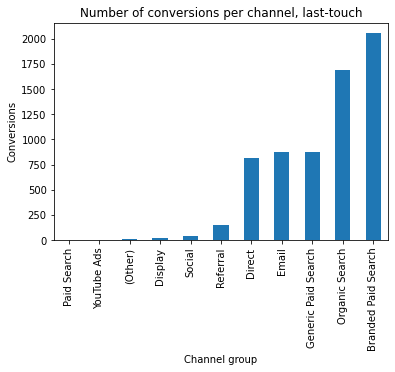

In [34]:
# results for all journeys 

# extract table of Transactions > 0
df_lasttouch = df_merge[df_merge['Transactions'] > 0]
# df_lasttouch

# check transactions assigned to each channel group 
df_lasttouch_review = df_lasttouch.groupby('Channel group')['Transactions'].sum().to_frame().reset_index()
print(df_lasttouch_review)

df_lasttouch_review.sort_values('Transactions').plot(x = 'Channel group', y = 'Transactions', kind = 'bar')
plt.ylabel('Conversions')
plt.title('Number of conversions per channel, last-touch')
plt.legend('', frameon = False)
plt.show()

In [35]:
# print(df_lasttouch['Transactions'].sum()) # 6535
# print(df_merge['Transactions'].sum()) # 6535
# print(df_model['Transactions'].sum()) # 6535
# print(df_attribution['Transactions'].sum()) # 6535

         Channel group  Transactions
0              (Other)             3
1  Branded Paid Search           482
2               Direct           134
3              Display            10
4                Email           218
5  Generic Paid Search           190
6       Organic Search           424
7             Referral            82
8               Social            12
9          YouTube Ads             1


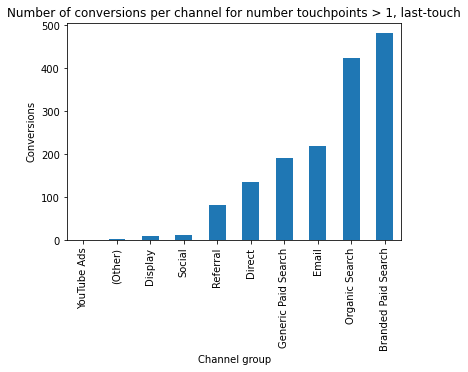

In [36]:
df_touchpoints_number_over1 = df_merge[df_merge['touchpoints_number'] > 1]
df_lasttouch_touchpoints_number_over1 = df_touchpoints_number_over1[df_touchpoints_number_over1['Transactions'] > 0]
df_lasttouch_touchpoints_number_over1_review = df_lasttouch_touchpoints_number_over1.groupby('Channel group')['Transactions'].sum().to_frame().reset_index()
print(df_lasttouch_touchpoints_number_over1_review)

df_lasttouch_touchpoints_number_over1_review.sort_values('Transactions').plot(x = 'Channel group', y = 'Transactions', kind = 'bar')
plt.ylabel('Conversions')
plt.title('Number of conversions per channel for number touchpoints > 1, last-touch')
plt.legend('', frameon = False)
plt.show()

### Last-touch attribution, with `ChannelAttribution` package

In [37]:
# import ChannelAttribution

In order to use the package {ChannelAttribution}, we need to create a table of aggregated data per path. We need to take into account that more than one transaction can be done within the same path i.e. touchpoint. 

We need to split the table into several ones to extract that information 

(!) I think result is the same as if doing it directly (without spliting into tables)

In [38]:
# counter of paths with Transactions > 1
table1 = df_model[df_model['Transactions'] > 1]
table1['counter_paths_with_transactions'] = 1
table1['counter_paths_without_transactions'] = 0

# counter of paths with Transactions == 1
table2 = df_model[df_model['Transactions'] == 1]
table2['counter_paths_with_transactions'] = 1
table2['counter_paths_without_transactions'] = 0

# counter of paths with Transactions == 0 
table3 = df_model[df_model['Transactions'] == 0]
table3['counter_paths_without_transactions'] = 1
table3['counter_paths_with_transactions'] = 0

# concatenate tables  
frames = [table1, table2, table3]
df_attribution = pd.concat(frames, join = 'outer')
# df_attribution

C:\Users\carol\AppData\Local\Temp\ipykernel_10788\1018037770.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table1['counter_paths_with_transactions'] = 1
C:\Users\carol\AppData\Local\Temp\ipykernel_10788\1018037770.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table1['counter_paths_without_transactions'] = 0
C:\Users\carol\AppData\Local\Temp\ipykernel_10788\1018037770.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [39]:
df_attribution = df_attribution[['Transactions', 'Transaction revenue', 'Channel group', 'counter_paths_without_transactions']]
df_attribution = df_attribution.groupby('Channel group').sum().reset_index()
# df_attribution 

# code to print into latex
#df_attribution_test1 = df_attribution.sort_values('Transactions', ascending = False)
#df_attribution_test1 = df_attribution_test1.iloc[np.r_[0:4, -4:0]]
# print(df_attribution_test1.to_latex())

df_attribution.sort_values('Transactions', ascending = False)

,Channel group,Transactions,Transaction revenue,counter_paths_without_transactions
104,Branded Paid Search,1574,258009.76,22045
1423,Organic Search,1266,259802.15,101700
1241,Generic Paid Search,687,74003.87,28705
495,Direct,681,112096.02,25002
1105,Email,656,57406.64,7429
...,...,...,...,...
894,Direct > Referral > Branded Paid Search > Bran...,0,0.00,2
895,Direct > Referral > Branded Paid Search > Soci...,0,0.00,1
896,Direct > Referral > Email,0,0.00,1
897,Direct > Referral > Generic Paid Search,0,0.00,2


In [40]:
m1_heuristics = ChannelAttribution.heuristic_models(Data = df_attribution, var_path = 'Channel group', var_conv = 'Transactions', var_value = 'Transaction revenue')
# m1_heuristics['last_touch_conversions'].sum()
m1_heuristics

,channel_name,first_touch_conversions,first_touch_value,last_touch_conversions,last_touch_value,linear_touch_conversions,linear_touch_value
0,(Other),16.0,2151.00,14.0,1807.00,15.126935,1975.991862
1,Email,861.0,84749.64,920.0,100251.46,888.277896,92188.258121
2,Display,26.0,3156.50,51.0,5046.50,41.782200,4222.547448
3,Social,36.0,2261.00,35.0,2513.00,37.402473,2452.303473
4,Organic Search,1640.0,319605.05,1708.0,336122.73,1675.289299,328154.575469
5,YouTube Ads,2.0,275.00,4.0,695.00,3.000000,485.000000
6,Branded Paid Search,2008.0,395770.21,2010.0,388241.51,2012.809062,393068.111596
7,Direct,904.0,142433.62,781.0,127500.12,839.751151,134431.443821
8,Referral,122.0,23213.40,171.0,24734.40,143.719881,23921.590089
9,Generic Paid Search,919.0,103831.18,840.0,90534.88,876.841103,96546.778120


## Modelling trial II: Markov Chain 

Ressources: 

- Markov Chains done by hand: https://towardsdatascience.com/marketing-channel-attribution-with-markov-chains-in-python-part-2-the-complete-walkthrough-733c65b23323 
- Channel Attribution package: https://channelattribution.io/pdf/PythonChannelAttribution.pdf 
- https://github.com/jmwoloso/pychattr/blob/master/pychattr/channel_attribution/_markov.py code for Markov Chains, done by hand 

### Markov Chain with `ChannelAttribution` package

- Approach to the atttribution model in a probabilistic way 
- It uses a k-order Markov representation to identify structural correlations in the customer journey data. This allows advertisers to give a more reliable assessment of the marketing contribution of each channel 
- Approach follows Anderl, Becker, Wangenheim, Schumann 2014 

#### Results for MM order = 1, all donor journeys 

With order = 1, we can represent it in a transition matrix. Otherwise not really

In [41]:
m2_mm = ChannelAttribution.markov_model(Data = df_attribution, 
                                        var_path = 'Channel group', 
                                        var_conv = 'Transactions', 
                                        var_null = 'counter_paths_without_transactions', 
                                        var_value = 'Transaction revenue',
                                        out_more = True)
# extract results 
m2_mm_result_table = m2_mm['result']
m2_mm_result_table.rename({'total_conversions':'markov_conversions', 'total_conversion_value':'markov_value'}, axis = 1, inplace = True)
m2_mm_transition_probs = m2_mm['transition_matrix']
m2_mm_removal_effects = m2_mm['removal_effects']

Number of simulations: 100000 - Reaching convergence (wait...): 18.00% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 13.37% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 10.25% > 5.00%
Number of simulations: 337500 - Reaching convergence (wait...): 9.33% > 5.00%
Number of simulations: 506250 - Reaching convergence (wait...): 8.23% > 5.00%
Number of simulations: 759375 - Reaching convergence (wait...): 7.20% > 5.00%
Number of simulations: 1139062 - Reaching convergence (wait...): 6.24% > 5.00%
Number of simulations: 1708593 - Reaching convergence (wait...): 5.59% > 5.00%
Number of simulations: 2562889 - Convergence reached: 4.96% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (47) is reached: 99.99%


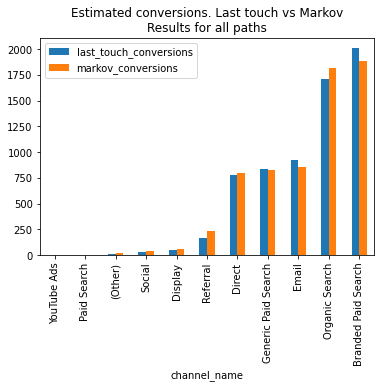

In [42]:
# merge results with heuristic ones 
results_models = pd.merge(left = m1_heuristics, right = m2_mm_result_table, on = 'channel_name', how = 'left')
# print(results_models)
plot_data = results_models[['channel_name', 'last_touch_conversions', 'last_touch_value', 'markov_conversions', 'markov_value']]
plot_data.sort_values('markov_conversions').plot(x = 'channel_name', y = ['last_touch_conversions', 'markov_conversions'], kind = 'bar')
plt.title('Estimated conversions. Last touch vs Markov\nResults for all paths')
plt.show()

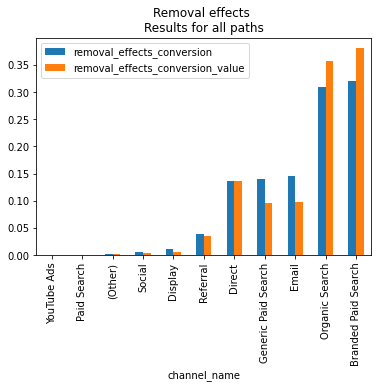

In [43]:
m2_mm_removal_effects.sort_values('removal_effects_conversion').plot(x = 'channel_name', y = ['removal_effects_conversion', 'removal_effects_conversion_value'], kind = 'bar')
# plt.legend(bbox_to_anchor=(0,1.02), loc="lower left")
plt.title('Removal effects \nResults for all paths')
plt.show()

Plot transition matrix. Code adapted from https://www.kaggle.com/code/koushiktcs12/attribution-modeling-in-marketing-python/notebook 

(!) Althought not specified, I want to think that channel numbers correspond to channel_name + 1 (because 0 is START)

In [44]:
# Convert start and conversion event to numeric values so we can sort and iterate through
m2_mm_transition_probs.replace('(start)', '0', inplace=True)
m2_mm_transition_probs.replace('(conversion)', '21', inplace=True)
m2_mm_transition_probs.replace('(null)', '22', inplace=True)

# Get unique origin and destination channels
channel_from_unique = m2_mm_transition_probs['channel_from'].unique().tolist()
channel_from_unique.sort(key=float)
channel_to_unique = m2_mm_transition_probs['channel_to'].unique().tolist()
channel_to_unique.sort(key=float)

# Create new matrix (empty) with origin and destination channels as columns and index
m2_mm_trans_matrix = pd.DataFrame(columns=channel_to_unique, index=channel_from_unique)
# m2_mm_trans_matrix 

# Assign the probabilities to the corresponding cells in our transition matrix
for f in channel_from_unique:
    for t in channel_to_unique:
        x = m2_mm_transition_probs[(m2_mm_transition_probs['channel_from'] == f) & (m2_mm_transition_probs['channel_to'] == t)]
        prob = x['transition_probability'].values
        if prob.size > 0:
            m2_mm_trans_matrix[t][f] = prob[0]
        else:
            m2_mm_trans_matrix[t][f] = 0

# Convert all probabilities to floats
m2_mm_trans_matrix = m2_mm_trans_matrix.apply(pd.to_numeric)

# Rename our start and conversion events
m2_mm_trans_matrix.rename(index={'0': 'START'}, inplace=True)
m2_mm_trans_matrix.rename(index={'1': '(Other)'}, inplace=True)
m2_mm_trans_matrix.rename(index={'2': 'Email'}, inplace=True)
m2_mm_trans_matrix.rename(index={'3': 'Display'}, inplace=True)
m2_mm_trans_matrix.rename(index={'4': 'Social'}, inplace=True)
m2_mm_trans_matrix.rename(index={'5': 'Organic'}, inplace=True)
m2_mm_trans_matrix.rename(index={'6': 'Youtube'}, inplace=True)
m2_mm_trans_matrix.rename(index={'7': 'Branded'}, inplace=True)
m2_mm_trans_matrix.rename(index={'8': 'Direct'}, inplace=True)
m2_mm_trans_matrix.rename(index={'9': 'Referral'}, inplace=True)
m2_mm_trans_matrix.rename(index={'10': 'Generic'}, inplace=True)
m2_mm_trans_matrix.rename(index={'11': 'Paid search'}, inplace=True)

m2_mm_trans_matrix.rename(columns={'21': 'CONVERSION'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'22': 'NULL'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'0': 'START'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'1': '(Other)'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'2': 'Email'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'3': 'Display'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'4': 'Social'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'5': 'Organic'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'6': 'Youtube'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'7': 'Branded'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'8': 'Direct'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'9': 'Referral'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'10': 'Generic'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'11': 'Paid search'}, inplace=True)

Transition matrix show probability of state ending up in conversion, no-conversion (Null) or in a different state. 

In [45]:
m2_mm_trans_matrix

,(Other),Email,Display,Social,Organic,Youtube,Branded,Direct,Referral,Generic,Paid search,CONVERSION,NULL
START,0.033591,0.029564,0.204093,0.043811,0.364358,0.007078,0.094833,0.098799,0.020742,0.099944,0.003187,0.000000,0.000000
(Other),0.000000,0.002336,0.008306,0.025437,0.004326,0.000260,0.001903,0.000346,0.001038,0.000606,0.000000,0.001211,0.954231
Email,0.010336,0.000000,0.010522,0.002235,0.024304,0.000466,0.010336,0.002235,0.006798,0.002421,0.000000,0.085669,0.844678
Display,0.000356,0.000585,0.000000,0.000342,0.002951,0.003422,0.001084,0.000314,0.000171,0.001697,0.000086,0.000727,0.988267
Social,0.011909,0.001757,0.005402,0.000000,0.015619,0.000195,0.003579,0.000325,0.002929,0.000846,0.000065,0.002278,0.955096
Organic,0.000374,0.002833,0.005839,0.002131,0.000000,0.000172,0.034336,0.001338,0.012455,0.008059,0.000045,0.012769,0.919651
Youtube,0.000748,0.000000,0.152263,0.000374,0.002993,0.000000,0.001122,0.000374,0.000000,0.000748,0.000000,0.001496,0.839880
Branded,0.000612,0.004308,0.005744,0.001303,0.192511,0.000186,0.000000,0.001250,0.006356,0.009095,0.000053,0.053453,0.725128
Direct,0.001151,0.006178,0.015960,0.003422,0.056903,0.001090,0.018201,0.000000,0.008873,0.006541,0.000485,0.023652,0.857545
Referral,0.000431,0.008503,0.005274,0.006027,0.149715,0.000108,0.022172,0.001722,0.000000,0.003659,0.000000,0.018405,0.783985


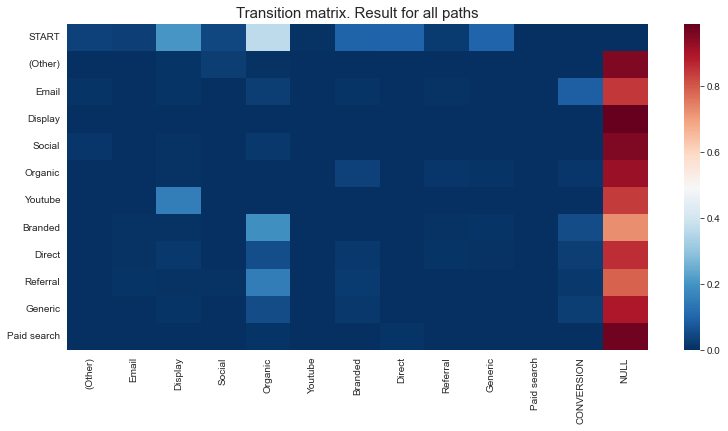

In [46]:
# Visualize this transition matrix in a heatmap
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(13, 6))
sns.heatmap(m2_mm_trans_matrix, cmap="RdBu_r")
plt.title('Transition matrix. Result for all paths', fontdict={'fontsize': 15})
plt.show()

In [47]:
# function to choose layout from those available 
def create_markov_Graph (layout_function, matrix_to_check = m2_mm_trans_matrix): 
    G = nx.DiGraph() 
    # add all edges with p > 0
    for row in matrix_to_check.index:
        i = 0
        for col in matrix_to_check.columns: 
            if matrix_to_check.loc[row][i] > 0.01: 
                G.add_edge(row, col, weight = round(matrix_to_check.loc[row][i], 3))
            i += 1
    print(G)
    # change color of special nodes 
    color_map = []
    for node in G: 
        if node in ['START', 'CONVERSION', 'NULL']: 
            color_map.append('indianred')
        else: 
            color_map.append('lightsteelblue')
    # change color of edges 
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    # positions for all nodes - seed for reproducibility
    pos = layout_function(G)
    # nodes - size, labels, arrows
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    fig, ax = plt.subplots(figsize=(20,20))
    nx.draw_networkx(G, pos, ax = ax, arrows = True, node_size = 1000, with_labels = True, node_color = color_map, edge_color = weights, edge_cmap=plt.cm.Blues)
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    plt.show()

DiGraph with 14 nodes and 44 edges


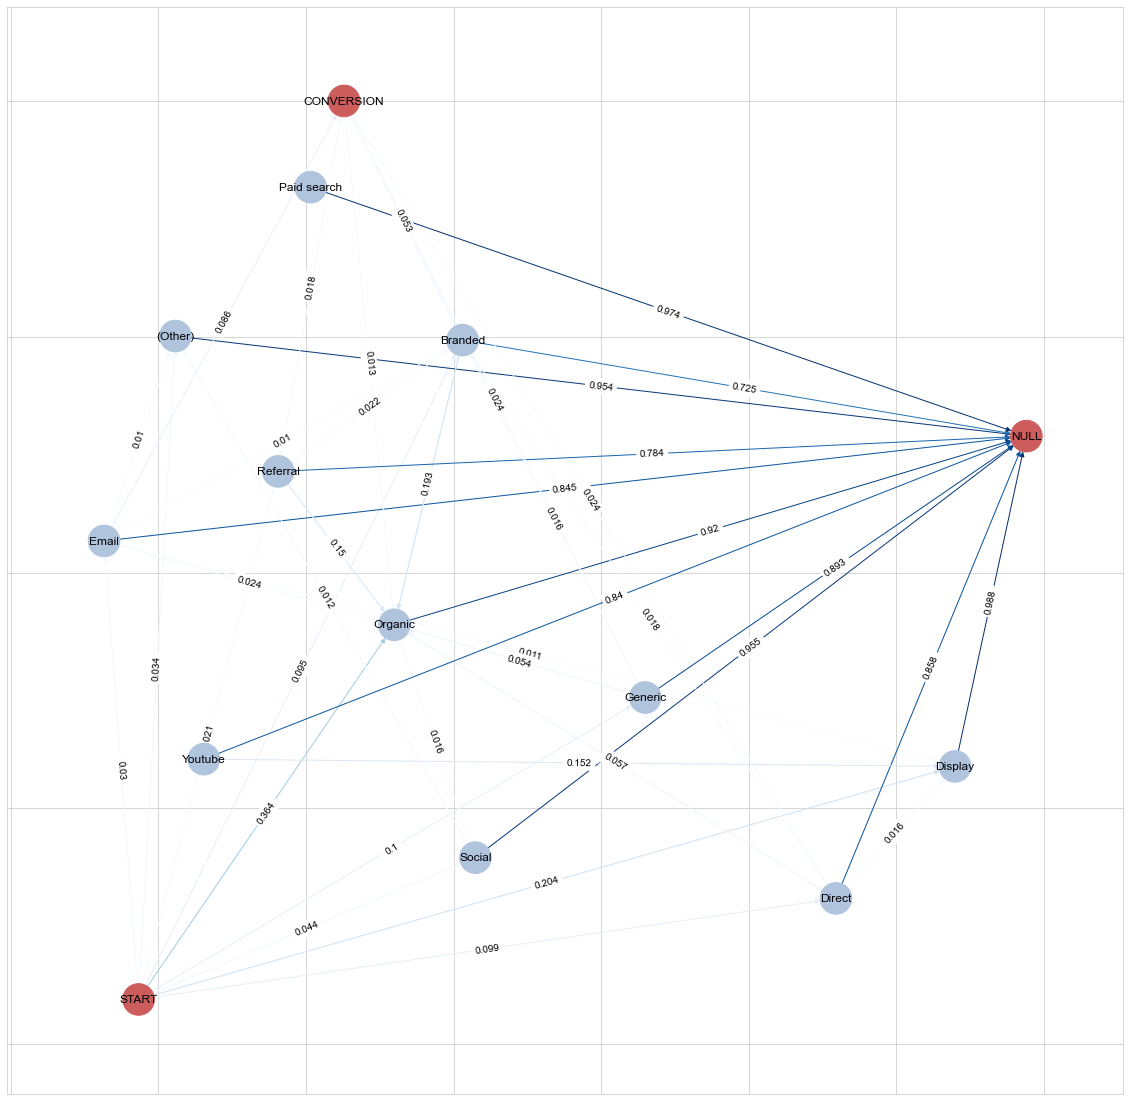

In [48]:
create_markov_Graph(layout_function = nx.spring_layout)

DiGraph with 14 nodes and 44 edges


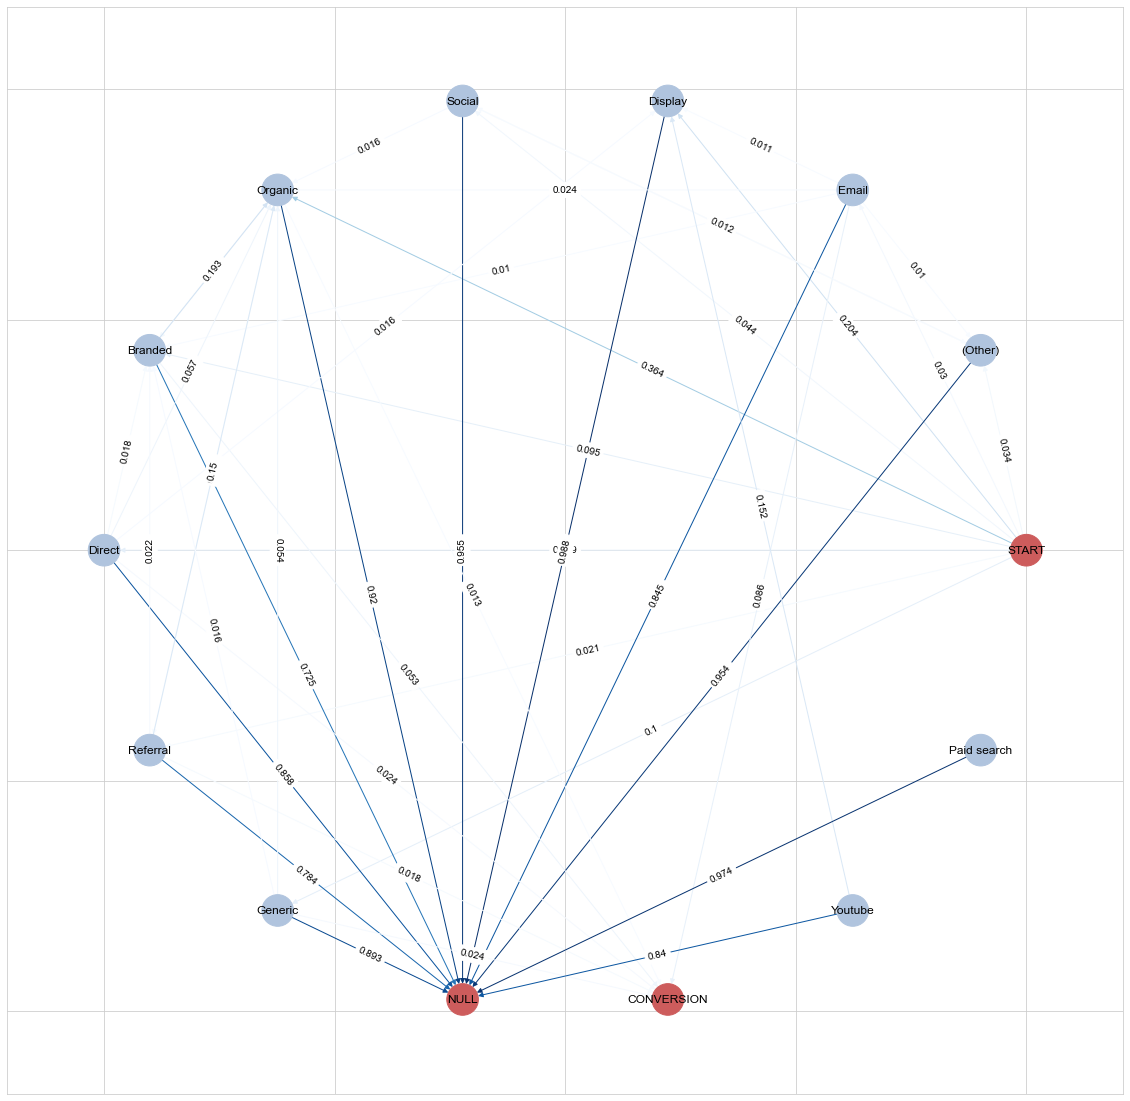

In [49]:
create_markov_Graph(layout_function = nx.circular_layout)

DiGraph with 14 nodes and 44 edges


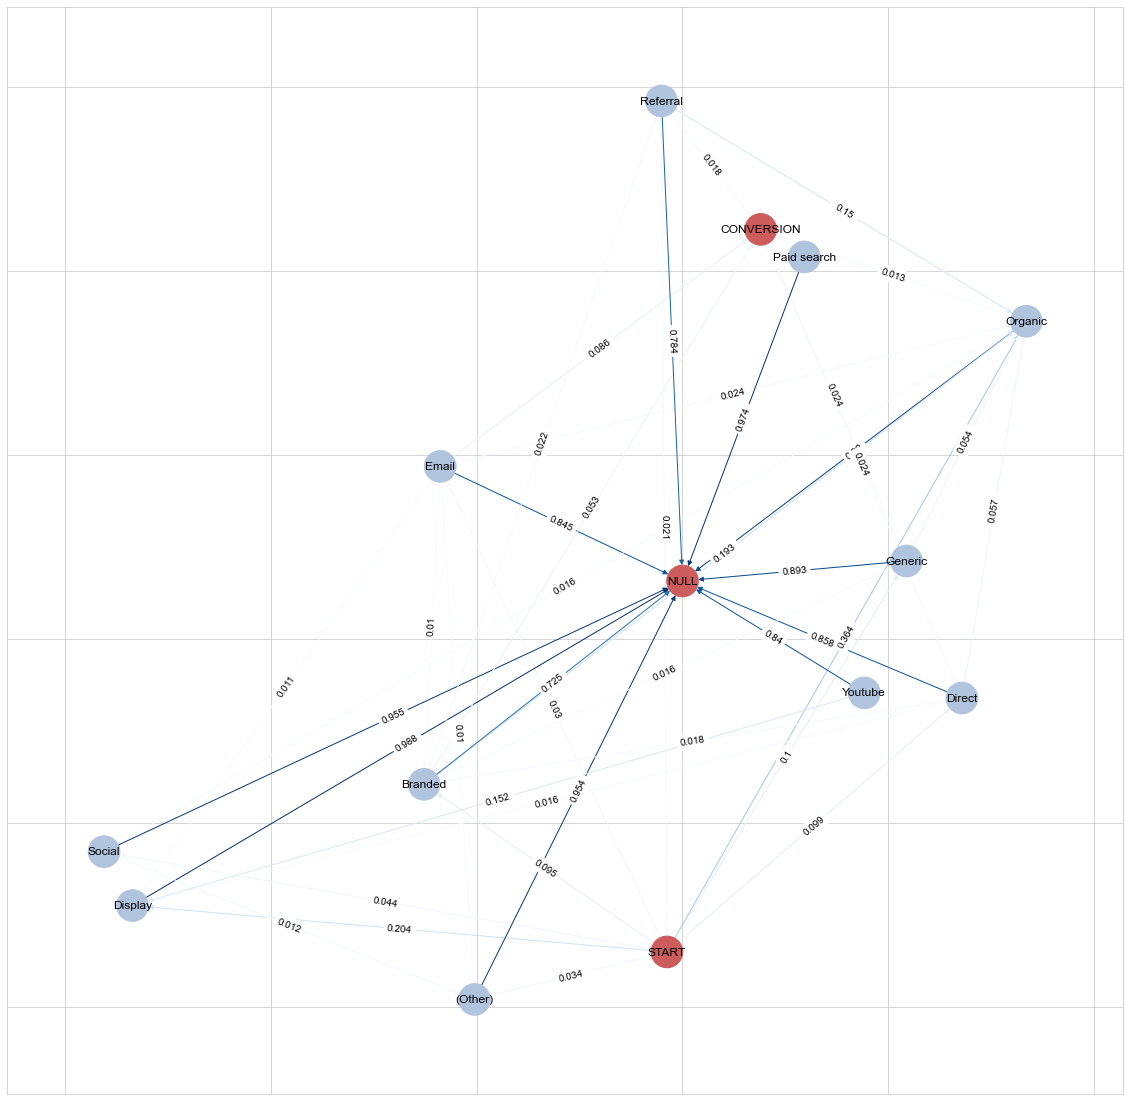

In [50]:
# create_markov_Graph(layout_function = nx.kamada_kawai_layout) # does not look good
# create_markov_Graph(layout_function = nx.planar_layout) # G is not planar
create_markov_Graph(layout_function = nx.random_layout)

DiGraph with 14 nodes and 44 edges


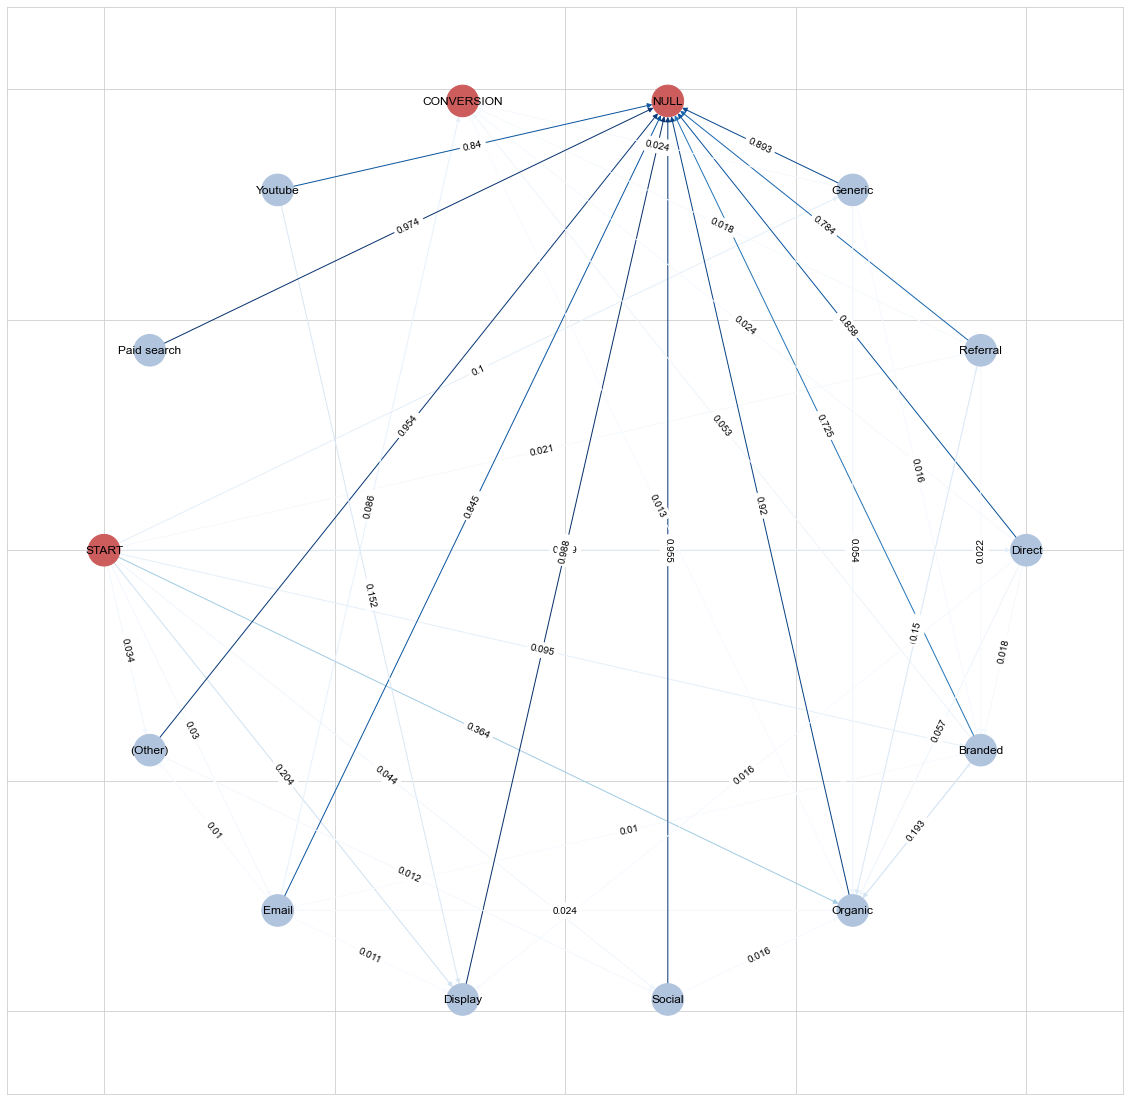

In [51]:
# create_markov_Graph(layout_function = nx.rescale_layout) # does not work 
create_markov_Graph(layout_function = nx.shell_layout) # looks like circular but slightly better 

DiGraph with 14 nodes and 44 edges


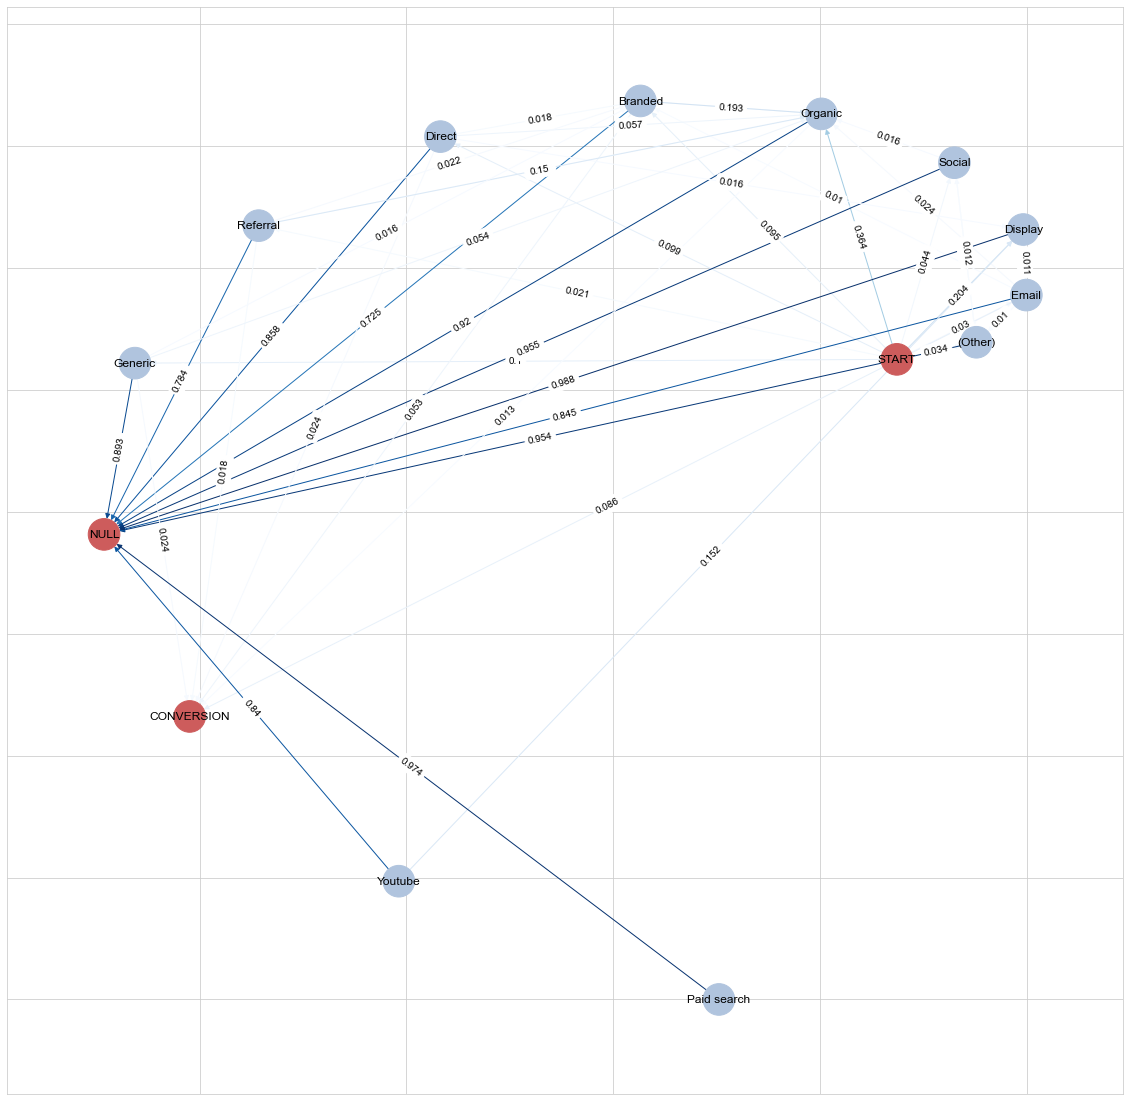

In [52]:
# create_markov_Graph(layout_function = nx.multipartite_layout) # error 
create_markov_Graph(layout_function = nx.spiral_layout)

#### Choosing best order for Markov chains 

Use auto MC. Extracts the result of order (up to 10) with highest AUC. I am not sure how AUC is calculated

In [53]:
mm_auto = ChannelAttribution.auto_markov_model(Data = df_attribution, var_path = 'Channel group', var_conv = 'Transactions', var_null = 'counter_paths_without_transactions', var_value = 'Transaction revenue', plot = True)
mm_auto

Suggested order: 5
Number of simulations: 100000 - Reaching convergence (wait...): 14.46% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 14.07% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 13.12% > 5.00%
Number of simulations: 337500 - Reaching convergence (wait...): 10.87% > 5.00%
Number of simulations: 506250 - Reaching convergence (wait...): 9.20% > 5.00%
Number of simulations: 759375 - Reaching convergence (wait...): 6.85% > 5.00%
Number of simulations: 1139062 - Reaching convergence (wait...): 5.39% > 5.00%
Number of simulations: 1708593 - Convergence reached: 4.61% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (133) is reached: 99.99%


,channel_name,total_conversions,total_conversion_value
0,(Other),16.244246,1421.121167
1,Email,837.481127,91620.018582
2,Display,46.326183,5122.123081
3,Social,41.513073,3224.043284
4,Organic Search,1751.972013,335179.926253
5,YouTube Ads,2.406555,522.402424
6,Branded Paid Search,1993.229147,386650.303871
7,Direct,844.099153,133011.968570
8,Referral,167.255570,24357.881500
9,Generic Paid Search,834.472933,96546.811266


In [54]:
# check AUC values vs order - data extracted in table for report 
mm_choose_order = ChannelAttribution.choose_order(Data = df_attribution, var_path = 'Channel group', var_conv = 'Transactions', var_null = 'counter_paths_without_transactions', plot = True)
print(mm_choose_order)

Suggested order: 5
(   order       auc      pauc
0    1.0  0.772335  0.772327
1    2.0  0.786546  0.786503
2    3.0  0.790106  0.789925
3    4.0  0.793116  0.792488
4    5.0  0.794389  0.792506
5    6.0  0.795155  0.790076, {'order=1':           fpr       tpr
0    0.000000  0.000000
1    0.027955  0.140780
2    0.027955  0.140780
3    0.027955  0.140780
4    0.027955  0.140780
..        ...       ...
96   0.696964  0.983933
97   0.696964  0.983933
98   0.696964  0.983933
99   0.749112  0.989901
100  1.000000  1.000000

[101 rows x 2 columns], 'order=2':           fpr       tpr
0    0.000000  0.000000
1    0.000003  0.000612
2    0.000003  0.000612
3    0.000003  0.000612
4    0.000003  0.000612
..        ...       ...
96   0.131484  0.504667
97   0.237179  0.649579
98   0.326069  0.755164
99   0.697411  0.988217
100  1.000000  1.000000

[101 rows x 2 columns], 'order=3':           fpr       tpr
0    0.000000  0.000000
1    0.000000  0.001989
2    0.000000  0.001989
3    0.000000  0.001

In [55]:
mm_choose_order_list = list(mm_choose_order)
mm_choose_order1 = mm_choose_order_list[1]['order=1']
mm_choose_order2 = mm_choose_order_list[1]['order=2']
mm_choose_order3 = mm_choose_order_list[1]['order=3']
mm_choose_order4 = mm_choose_order_list[1]['order=4']
mm_choose_order5 = mm_choose_order_list[1]['order=5']
mm_choose_order6 = mm_choose_order_list[1]['order=6']

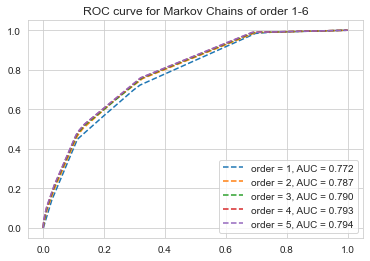

In [56]:
# plot ROC + AUC for each MK order 

def extract_axis (data):
    x = data['fpr']
    y = data['tpr']
    return (x,y)

x1,y1 = extract_axis(mm_choose_order1)
x2,y2 = extract_axis(mm_choose_order2)
x3,y3 = extract_axis(mm_choose_order3)
x4,y4 = extract_axis(mm_choose_order4)
x5,y5 = extract_axis(mm_choose_order5)
x6,y6 = extract_axis(mm_choose_order6)

plt.plot(x1, y1, label = 'order = 1, AUC = 0.772', linestyle = '--')
plt.plot(x2, y2, label = 'order = 2, AUC = 0.787', linestyle = '--')
plt.plot(x3, y3, label = 'order = 3, AUC = 0.790', linestyle = '--')
plt.plot(x4, y4, label = 'order = 4, AUC = 0.793', linestyle = '--')
plt.plot(x5, y5, label = 'order = 5, AUC = 0.794', linestyle = '--')
# plt.plot(x6, y6, label = 'order = 6, AUC = 0.795', linestyle = '--')
plt.legend()
plt.title('ROC curve for Markov Chains of order 1-6')
plt.show()

#### Results for MM order = 1, donor journeys with number of touchpoints > 1 

Results in terms of marketing budget allocation for most journeys can be actually done based on a explorative analysis. Therefore, we filtered all those paths with touchpoints == 1 and check the results for longer paths. 

Results were finally not included in the report because they do not represent the "real picture" of the data under study.

In [57]:
df_model_more_touchpoints = df_model[df_model['touchpoints_number'] > 1]

# counter of paths with Transactions > 1
table1 = df_model_more_touchpoints[df_model_more_touchpoints['Transactions'] > 1]
table1['counter_paths_with_transactions'] = 1
table1['counter_paths_without_transactions'] = 0

# counter of paths with Transactions == 1
table2 = df_model_more_touchpoints[df_model_more_touchpoints['Transactions'] == 1]
table2['counter_paths_with_transactions'] = 1
table2['counter_paths_without_transactions'] = 0

# counter of paths with Transactions == 0 
table3 = df_model_more_touchpoints[df_model_more_touchpoints['Transactions'] == 0]
table3['counter_paths_without_transactions'] = 1
table3['counter_paths_with_transactions'] = 0

# concatenate tables  
frames = [table1, table2, table3]
df_attribution_more_touchpoints = pd.concat(frames, join = 'outer')
# df_attribution

# calculate last touchpoint for df_attribution_more_touchpoints
m1_heuristics_reduced = ChannelAttribution.heuristic_models(Data = df_attribution_more_touchpoints, var_path = 'Channel group', var_conv = 'Transactions', var_value = 'Transaction revenue')
# m1_heuristics['last_touch_conversions'].sum()
m1_heuristics_reduced

C:\Users\carol\AppData\Local\Temp\ipykernel_10788\3111909872.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table1['counter_paths_with_transactions'] = 1
C:\Users\carol\AppData\Local\Temp\ipykernel_10788\3111909872.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table1['counter_paths_without_transactions'] = 0
C:\Users\carol\AppData\Local\Temp\ipykernel_10788\3111909872.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,channel_name,first_touch_conversions,first_touch_value,last_touch_conversions,last_touch_value,linear_touch_conversions,linear_touch_value
0,Direct,223.0,30337.60,100.0,15404.10,158.751151,22335.423821
1,Referral,57.0,14041.00,106.0,15562.00,78.719881,14749.190089
2,Organic Search,374.0,59802.90,442.0,76320.58,409.289299,68352.425469
3,Branded Paid Search,434.0,137760.45,436.0,130231.75,438.809062,135058.351596
4,Generic Paid Search,232.0,29827.31,153.0,16531.01,189.841103,22542.908120
5,Email,205.0,27343.00,264.0,42844.82,232.277896,34781.618121
6,Social,12.0,583.00,11.0,835.00,13.402473,774.303473
7,Display,13.0,1706.50,38.0,3596.50,28.782200,2772.547448
8,(Other),6.0,800.00,4.0,456.00,5.126935,624.991862
9,YouTube Ads,0.0,0.00,2.0,420.00,1.000000,210.000000


Number of simulations: 100000 - Reaching convergence (wait...): 10.88% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 9.22% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 7.11% > 5.00%
Number of simulations: 337500 - Reaching convergence (wait...): 6.40% > 5.00%
Number of simulations: 506250 - Reaching convergence (wait...): 5.30% > 5.00%
Number of simulations: 759375 - Convergence reached: 4.72% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (47) is reached: 99.99%


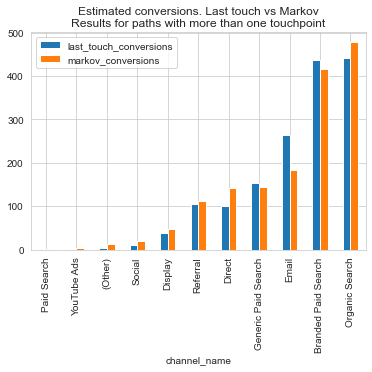

In [58]:
m2_mm_reduced = ChannelAttribution.markov_model(Data = df_attribution_more_touchpoints, 
                                        var_path = 'Channel group', 
                                        var_conv = 'Transactions', 
                                        var_null = 'counter_paths_without_transactions', 
                                        var_value = 'Transaction revenue',
                                        out_more = True)
# check results in terms of conversion and conversion value 
m2_mm_result_table = m2_mm_reduced['result']
m2_mm_transition_probs = m2_mm_reduced['transition_matrix']
m2_mm_removal_effects = m2_mm_reduced['removal_effects']

# merge results with heuristic ones 
m2_mm_result_table.rename({'total_conversions':'markov_conversions', 'total_conversion_value':'markov_value'}, axis = 1, inplace = True)
results_models = pd.merge(left = m1_heuristics_reduced, right = m2_mm_result_table, on = 'channel_name', how = 'left')
# print(results_models)
plot_data = results_models[['channel_name', 'last_touch_conversions', 'last_touch_value', 'markov_conversions', 'markov_value']]
plot_data.sort_values('markov_conversions').plot(x = 'channel_name', y = ['last_touch_conversions', 'markov_conversions'], kind = 'bar')
plt.title('Estimated conversions. Last touch vs Markov\nResults for paths with more than one touchpoint')
plt.show()

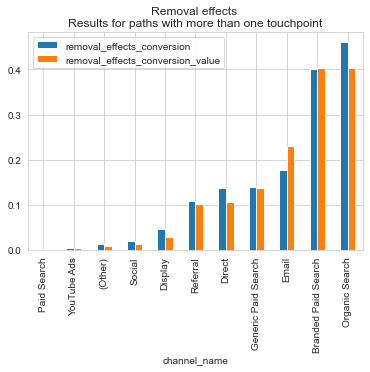

In [59]:
m2_mm_removal_effects.sort_values('removal_effects_conversion').plot(x = 'channel_name', y = ['removal_effects_conversion', 'removal_effects_conversion_value'], kind = 'bar')
# plt.legend(bbox_to_anchor=(0,1.02), loc="lower left")
plt.title('Removal effects \nResults for paths with more than one touchpoint')
plt.show()

In [60]:
print(m2_mm_transition_probs.channel_to.value_counts())

# adapted code from https://www.kaggle.com/code/koushiktcs12/attribution-modeling-in-marketing-python/notebook 
m2_mm_transition_probs = m2_mm_reduced['transition_matrix']
# m2_mm_transition_probs
# Convert start and conversion event to numeric values so we can sort and iterate through
m2_mm_transition_probs.replace('(start)', '0', inplace=True)
m2_mm_transition_probs.replace('(conversion)', '21', inplace=True)
m2_mm_transition_probs.replace('(null)', '22', inplace=True)

# Get unique origin and destination channels
channel_from_unique = m2_mm_transition_probs['channel_from'].unique().tolist()
channel_from_unique.sort(key=float)
channel_to_unique = m2_mm_transition_probs['channel_to'].unique().tolist()
channel_to_unique.sort(key=float)

# Create new matrix (empty) with origin and destination channels as columns and index
m2_mm_trans_matrix = pd.DataFrame(columns=channel_to_unique, index=channel_from_unique)
# m2_mm_trans_matrix 

# Assign the probabilities to the corresponding cells in our transition matrix
for f in channel_from_unique:
    for t in channel_to_unique:
        x = m2_mm_transition_probs[(m2_mm_transition_probs['channel_from'] == f) & (m2_mm_transition_probs['channel_to'] == t)]
        prob = x['transition_probability'].values
        if prob.size > 0:
            m2_mm_trans_matrix[t][f] = prob[0]
        else:
            m2_mm_trans_matrix[t][f] = 0

# Convert all probabilities to floats
m2_mm_trans_matrix = m2_mm_trans_matrix.apply(pd.to_numeric)

# Rename our start and conversion events
m2_mm_trans_matrix.rename(index={'0': 'START'}, inplace=True)
m2_mm_trans_matrix.rename(index={'1': '(Other)'}, inplace=True)
m2_mm_trans_matrix.rename(index={'2': 'Email'}, inplace=True)
m2_mm_trans_matrix.rename(index={'3': 'Display'}, inplace=True)
m2_mm_trans_matrix.rename(index={'4': 'Social'}, inplace=True)
m2_mm_trans_matrix.rename(index={'5': 'Organic'}, inplace=True)
m2_mm_trans_matrix.rename(index={'6': 'Youtube'}, inplace=True)
m2_mm_trans_matrix.rename(index={'7': 'Branded'}, inplace=True)
m2_mm_trans_matrix.rename(index={'8': 'Direct'}, inplace=True)
m2_mm_trans_matrix.rename(index={'9': 'Referral'}, inplace=True)
m2_mm_trans_matrix.rename(index={'10': 'Generic'}, inplace=True)
m2_mm_trans_matrix.rename(index={'11': 'Paid search'}, inplace=True)

m2_mm_trans_matrix.rename(columns={'21': 'CONVERSION'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'22': 'NULL'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'0': 'START'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'1': '(Other)'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'2': 'Email'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'3': 'Display'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'4': 'Social'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'5': 'Organic'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'6': 'Youtube'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'7': 'Branded'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'8': 'Direct'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'9': 'Referral'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'10': 'Generic'}, inplace=True)
m2_mm_trans_matrix.rename(columns={'11': 'Paid search'}, inplace=True)

1               11
3               11
4               11
5               11
7               11
8               11
(null)          11
9               10
10              10
(conversion)    10
6                9
2                9
11               7
Name: channel_to, dtype: int64


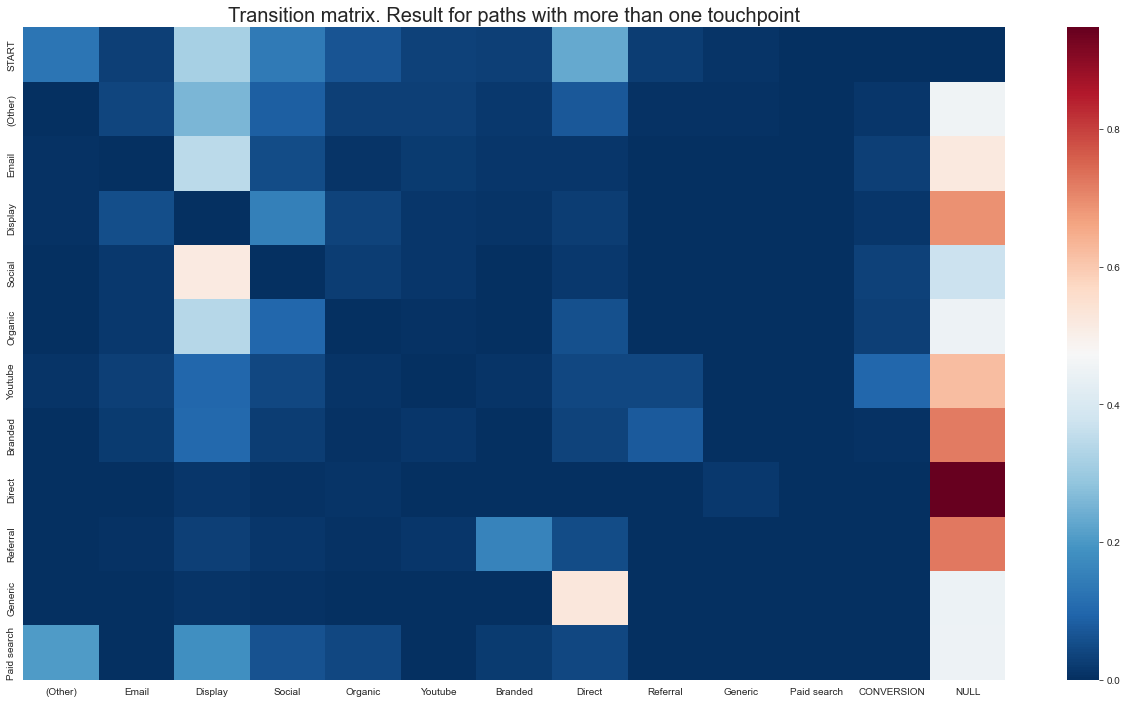

In [61]:
# Visualize this transition matrix in a heatmap
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(22, 12))
sns.heatmap(m2_mm_trans_matrix, cmap="RdBu_r")
plt.title('Transition matrix. Result for paths with more than one touchpoint', fontdict={'fontsize': 20})
plt.show()

In [62]:
m2_mm_trans_matrix

,(Other),Email,Display,Social,Organic,Youtube,Branded,Direct,Referral,Generic,Paid search,CONVERSION,NULL
START,0.125921,0.028911,0.316409,0.139391,0.066198,0.030507,0.027082,0.231576,0.025844,0.007873,0.000287,0.000000,0.000000
(Other),0.000000,0.039929,0.256064,0.081902,0.029436,0.027800,0.015399,0.071818,0.005179,0.004906,0.002180,0.013628,0.451758
Email,0.003963,0.000000,0.344563,0.051028,0.008422,0.019569,0.013872,0.012138,0.000991,0.000248,0.000000,0.026257,0.518950
Display,0.005812,0.054091,0.000000,0.149123,0.035000,0.012305,0.009253,0.025357,0.001623,0.000747,0.000195,0.014351,0.692143
Social,0.003361,0.017091,0.517663,0.000000,0.024457,0.011585,0.003504,0.015446,0.001645,0.000501,0.000143,0.031178,0.373427
Organic,0.001627,0.015371,0.338879,0.098011,0.000000,0.006148,0.003074,0.056058,0.000542,0.002170,0.000362,0.027667,0.450090
Youtube,0.009043,0.027506,0.098342,0.041824,0.009797,0.000000,0.009043,0.042577,0.041824,0.001884,0.000000,0.099472,0.618689
Branded,0.002106,0.018955,0.101095,0.023168,0.005476,0.011373,0.000000,0.034962,0.077085,0.001264,0.000421,0.004634,0.719461
Direct,0.001420,0.000774,0.013358,0.004904,0.007679,0.002646,0.001549,0.000000,0.001613,0.015488,0.000387,0.002452,0.947728
Referral,0.002128,0.006383,0.026596,0.011702,0.003723,0.014362,0.156383,0.051064,0.000000,0.001596,0.000000,0.002128,0.723936


#### Results with auto MM (order = 5), all donor journeys

I do not really understand how is the suggested order 5, when 3/4 of paths have a single touchoint
I also do not really know if its possible to show a transition matrix if order > 1 

In [63]:
mm_order5 = ChannelAttribution.markov_model(Data = df_attribution, var_path = 'Channel group', var_conv = 'Transactions', var_null = 'counter_paths_without_transactions', var_value = 'Transaction revenue', order = 5, out_more = True )
mm_order5

Number of simulations: 100000 - Reaching convergence (wait...): 14.46% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 14.07% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 13.12% > 5.00%
Number of simulations: 337500 - Reaching convergence (wait...): 10.87% > 5.00%
Number of simulations: 506250 - Reaching convergence (wait...): 9.20% > 5.00%
Number of simulations: 759375 - Reaching convergence (wait...): 6.85% > 5.00%
Number of simulations: 1139062 - Reaching convergence (wait...): 5.39% > 5.00%
Number of simulations: 1708593 - Convergence reached: 4.61% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (133) is reached: 99.99%


{'result':            channel_name  total_conversions  total_conversion_value
 0               (Other)          16.244246             1421.121167
 1                 Email         837.481127            91620.018582
 2               Display          46.326183             5122.123081
 3                Social          41.513073             3224.043284
 4        Organic Search        1751.972013           335179.926253
 5           YouTube Ads           2.406555              522.402424
 6   Branded Paid Search        1993.229147           386650.303871
 7                Direct         844.099153           133011.968570
 8              Referral         167.255570            24357.881500
 9   Generic Paid Search         834.472933            96546.811266
 10          Paid Search           0.000000                0.000000,
 'transition_matrix':      channel_from channel_to  transition_probability
 0         (start)          1                0.029237
 1         (start)        1 1               

In [64]:
mm_auto = ChannelAttribution.auto_markov_model(Data = df_attribution, var_path = 'Channel group', var_conv = 'Transactions', var_null = 'counter_paths_without_transactions', var_value = 'Transaction revenue', out_more = True)
# mm_auto

# extract tables of results 
mm_auto_result_table = mm_auto['result']
mm_auto_transition_probs = mm_auto['transition_matrix']
mm_auto_removal_effects = mm_auto['removal_effects']

Suggested order: 5
Number of simulations: 100000 - Reaching convergence (wait...): 14.46% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 14.07% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 13.12% > 5.00%
Number of simulations: 337500 - Reaching convergence (wait...): 10.87% > 5.00%
Number of simulations: 506250 - Reaching convergence (wait...): 9.20% > 5.00%
Number of simulations: 759375 - Reaching convergence (wait...): 6.85% > 5.00%
Number of simulations: 1139062 - Reaching convergence (wait...): 5.39% > 5.00%
Number of simulations: 1708593 - Convergence reached: 4.61% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (133) is reached: 99.99%


In [65]:
mm_auto_result_table.rename({'total_conversions':'markov_conversions_order5', 'total_conversion_value':'markov_value_order5'}, axis = 1, inplace = True)
# merge with last-touch
results_all_models = pd.merge(left = m1_heuristics, right = mm_auto_result_table, on = 'channel_name', how = 'left')
# results_all_models

In [66]:
# markov order 1 
m2_mm = ChannelAttribution.markov_model(Data = df_attribution, 
                                        var_path = 'Channel group', 
                                        var_conv = 'Transactions', 
                                        var_null = 'counter_paths_without_transactions', 
                                        var_value = 'Transaction revenue',
                                        out_more = True)
# extract results 
m2_mm_result_table = m2_mm['result']
m2_mm_result_table.rename({'total_conversions':'markov_conversions_order1', 'total_conversion_value':'markov_value_order1'}, axis = 1, inplace = True)
m2_mm_transition_probs = m2_mm['transition_matrix']
m2_mm_removal_effects = m2_mm['removal_effects']

Number of simulations: 100000 - Reaching convergence (wait...): 18.00% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 13.37% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 10.25% > 5.00%
Number of simulations: 337500 - Reaching convergence (wait...): 9.33% > 5.00%
Number of simulations: 506250 - Reaching convergence (wait...): 8.23% > 5.00%
Number of simulations: 759375 - Reaching convergence (wait...): 7.20% > 5.00%
Number of simulations: 1139062 - Reaching convergence (wait...): 6.24% > 5.00%
Number of simulations: 1708593 - Reaching convergence (wait...): 5.59% > 5.00%
Number of simulations: 2562889 - Convergence reached: 4.96% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (47) is reached: 99.99%


In [67]:
# merge with markov order 1 
results_all_models = pd.merge(left = results_all_models, right = m2_mm_result_table, on = 'channel_name')
results_all_models

,channel_name,first_touch_conversions,first_touch_value,last_touch_conversions,last_touch_value,linear_touch_conversions,linear_touch_value,markov_conversions_order5,markov_value_order5,markov_conversions_order1,markov_value_order1
0,(Other),16.0,2151.00,14.0,1807.00,15.126935,1975.991862,16.244246,1421.121167,17.374946,2118.411867
1,Email,861.0,84749.64,920.0,100251.46,888.277896,92188.258121,837.481127,91620.018582,858.645582,94017.593507
2,Display,26.0,3156.50,51.0,5046.50,41.782200,4222.547448,46.326183,5122.123081,62.630619,6159.941269
3,Social,36.0,2261.00,35.0,2513.00,37.402473,2452.303473,41.513073,3224.043284,35.558029,3463.270035
4,Organic Search,1640.0,319605.05,1708.0,336122.73,1675.289299,328154.575469,1751.972013,335179.926253,1817.096086,345257.797996
5,YouTube Ads,2.0,275.00,4.0,695.00,3.000000,485.000000,2.406555,522.402424,1.212206,168.430572
6,Branded Paid Search,2008.0,395770.21,2010.0,388241.51,2012.809062,393068.111596,1993.229147,386650.303871,1886.191801,368526.878097
7,Direct,904.0,142433.62,781.0,127500.12,839.751151,134431.443821,844.099153,133011.968570,799.247511,131422.976215
8,Referral,122.0,23213.40,171.0,24734.40,143.719881,23921.590089,167.255570,24357.881500,231.127187,33531.991440
9,Generic Paid Search,919.0,103831.18,840.0,90534.88,876.841103,96546.778120,834.472933,96546.811266,823.895690,92644.101593


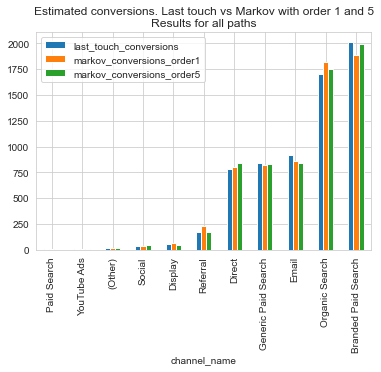

In [68]:
plot_data = results_all_models[['channel_name', 'last_touch_conversions', 'last_touch_value', 'markov_conversions_order1', 'markov_value_order1', 'markov_conversions_order5', 'markov_value_order5']]
plot_data.sort_values('last_touch_conversions').plot(x = 'channel_name', y = ['last_touch_conversions', 'markov_conversions_order1', 'markov_conversions_order5'], kind = 'bar')
plt.title('Estimated conversions. Last touch vs Markov with order 1 and 5\nResults for all paths')
plt.show()

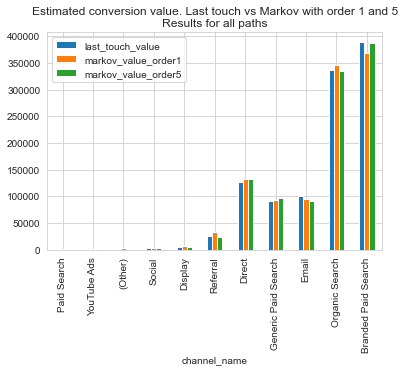

In [69]:
plot_data = results_all_models[['channel_name', 'last_touch_conversions', 'last_touch_value', 'markov_conversions_order1', 'markov_value_order1', 'markov_conversions_order5', 'markov_value_order5']]
plot_data.sort_values('last_touch_conversions').plot(x = 'channel_name', y = ['last_touch_value', 'markov_value_order1', 'markov_value_order5'], kind = 'bar')
plt.title('Estimated conversion value. Last touch vs Markov with order 1 and 5\nResults for all paths')
plt.show()

In [70]:
# check removal effects 
m2_mm_removal_effects.rename({'removal_effects_conversion':'removal_conversion_markov_order1', 'removal_effects_conversion_value':'removal_value_markov_order1'}, axis = 1, inplace = True)
mm_auto_removal_effects.rename({'removal_effects_conversion':'removal_conversion_markov_order5', 'removal_effects_conversion_value':'removal_value_markov_order5'}, axis = 1, inplace = True)
all_removal_effects = pd.merge(left = m2_mm_removal_effects, right = mm_auto_removal_effects, on = 'channel_name')
all_removal_effects

,channel_name,removal_conversion_markov_order1,removal_value_markov_order1,removal_conversion_markov_order5,removal_value_markov_order5
0,(Other),0.002958,0.002189,0.002854,0.001481
1,Email,0.146159,0.097160,0.147146,0.095449
2,Display,0.010661,0.006366,0.008140,0.005336
3,Social,0.006053,0.003579,0.007294,0.003359
4,Organic Search,0.309306,0.356796,0.307822,0.349188
5,YouTube Ads,0.000206,0.000174,0.000423,0.000544
6,Branded Paid Search,0.321067,0.380843,0.350211,0.402809
7,Direct,0.136048,0.135815,0.148309,0.138571
8,Referral,0.039342,0.034653,0.029387,0.025376
9,Generic Paid Search,0.140243,0.095740,0.146617,0.100582


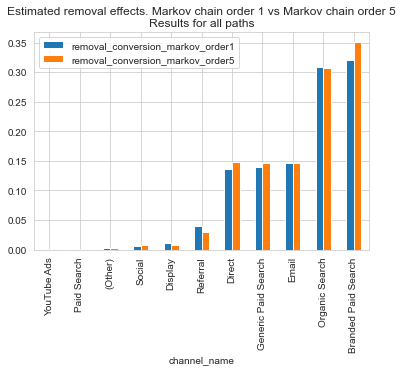

In [71]:
plot_data = all_removal_effects[['channel_name', 'removal_conversion_markov_order1', 'removal_value_markov_order1', 'removal_conversion_markov_order5', 'removal_value_markov_order5']]
plot_data.sort_values('removal_conversion_markov_order1').plot(x = 'channel_name', y = ['removal_conversion_markov_order1', 'removal_conversion_markov_order5'], kind = 'bar')
plt.title('Estimated removal effects. Markov chain order 1 vs Markov chain order 5\nResults for all paths')
plt.show()

#### Results for MM order = 5, donor journeys with number of touchpoints > 1 

Results are almost the same for last-touch and Markov, probably because most of our paths just contain one touchpoint (whether ending up in a conversion or not). Therefore, we repeated the study for those with touchpoints > 1

**Not included in report**

In [72]:
m3_auto_mm_more_touchpoints = ChannelAttribution.auto_markov_model(Data = df_attribution_more_touchpoints, var_path = 'Channel group', var_conv = 'Transactions', var_null = 'counter_paths_without_transactions', var_value = 'Transaction revenue')
# m3_auto_mm_more_touchpoints # == result_table

Suggested order: 4
Number of simulations: 100000 - Reaching convergence (wait...): 10.88% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 8.53% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 6.94% > 5.00%
Number of simulations: 337500 - Reaching convergence (wait...): 5.48% > 5.00%
Number of simulations: 506250 - Reaching convergence (wait...): 5.48% > 5.00%
Number of simulations: 759375 - Reaching convergence (wait...): 5.00% > 5.00%
Number of simulations: 1139062 - Convergence reached: 4.33% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (120) is reached: 99.99%


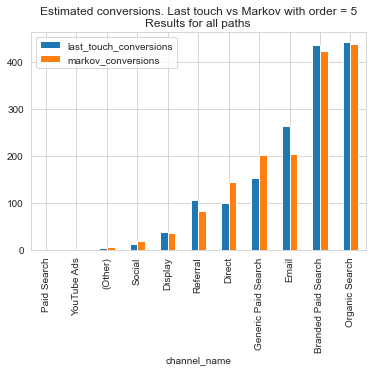

In [73]:
result_table = m3_auto_mm_more_touchpoints
result_table.rename({'total_conversions':'markov_conversions', 'total_conversion_value':'markov_value'}, axis = 1, inplace = True)
results_models = pd.merge(left = m1_heuristics_reduced, right = result_table, on = 'channel_name', how = 'left')
plot_data = results_models[['channel_name', 'last_touch_conversions', 'last_touch_value', 'markov_conversions', 'markov_value']]
plot_data.sort_values('markov_conversions').plot(x = 'channel_name', y = ['last_touch_conversions', 'markov_conversions'], kind = 'bar')
plt.title('Estimated conversions. Last touch vs Markov with order = 5\nResults for all paths')
plt.show()

### Markov Chains with `ChannelAttributionPro` - attribution on path level

**Package needs Python 3.8**. A new virtual environment using Python 3.8.8 was created for this task. Requirements (i.e. packages) used in original virtual environment using Python 3.9 were freezed into a requirements text file and installed into the new virtual environment using Python 3.8. 

In [ ]:
# Code needed to install package from their repo 
# Package needs Python 3.8 to work (it does not work with Python 3.9)
"""
pkg_vers=None
vso=None

repo="https://app.channelattribution.net/repository/pkg"
pkg_list="https://app.channelattribution.net/repository/package_list"

import os

os.system('pip install setuptools wheel cython numpy pandas matplotlib psutil distro requests')

try:
    del ChannelAttribution
    del ChannelAttributionPro
    os.system('pip uninstall --yes ChannelAttribution')
    os.system('pip uninstall --yes ChannelAttributionPro')
except:
    x=0


import sys
import re
import pandas as pd
import urllib.request
import requests
import zipfile
import shutil
import sys
import distro
import platform

system=platform.system().lower()
if system=="linux":
    so=distro.name().lower()
    if "debian" in so:
        so="debian"
    if "ubuntu" in so:
        so="ubuntu"
        vso=distro.version()
        vso=vso.split(".")[0]
    if ("redhat" in so) | ("fedora" in so):
        so="centos"
elif system=="windows":
    so="windows"
elif system=="darwin":
    so="macos"
    
py_vers=re.findall(r"[0-9]+.[0-9]+", sys.version)[0]
    
try:

    tab_pkg=pd.read_csv(pkg_list,sep="/",dtype='str',header=None)
    tab_pkg.columns=["V0","so","so_version","lang","lang_version","pkg_version","file"]
    del tab_pkg['V0']
           
    if vso==None:
         tmp=tab_pkg[(tab_pkg.so==so) & (tab_pkg.lang=="python") & (tab_pkg.lang_version==py_vers)]
         vso=tmp['so_version'].max()
    
    if pkg_vers==None: 
         tmp=tab_pkg[(tab_pkg.so==so) & (tab_pkg.lang=="python") & (tab_pkg.lang_version==py_vers)]
         tmp['pkg_vers_1']=[int(re.sub('\.','',re.findall(r'^\d+.',x)[0])) for x in tmp['pkg_version']]
         tmp['pkg_vers_2']=[int(re.sub('\.','',re.findall(r'.\d+',x)[0])) for x in tmp['pkg_version']]
         tmp['pkg_vers_3']=[int(re.sub('\.','',re.findall(r'\d+$',x)[0])) for x in tmp['pkg_version']]
         tmp=tmp.sort_values(by=['pkg_vers_1','pkg_vers_2','pkg_vers_3'])
         pkg_vers=tmp['pkg_version'].iloc[-1]
    
    pkg_name=tab_pkg.loc[(tab_pkg.so==so) & (tab_pkg.so_version==vso) & (tab_pkg.lang=="python") & (tab_pkg.lang_version==py_vers) & (tab_pkg.pkg_version==pkg_vers),'file'].iloc[0]
    url="{repo}/{so}/{vso}/python/{py_vers}/{pkg_vers}/{pkg_name}".format(repo=repo,so=so,vso=vso,py_vers=py_vers,pkg_vers=pkg_vers,pkg_name=pkg_name)

    # flg_found=0    
    # for p in sys.path:
    #     try:
    #         y=pd.Series(os.listdir(p))
    #         y=y[y.str.contains('ChannelAttributionPro')]
    #         os.remove(p+'/'+y.values[0])
    #         flg_found=1
    #         break
    #     except:
    #         x=0
    
    for p in sys.path:
        try:
            y=pd.Series(os.listdir(p))
            y=y[y.str.contains("ChannelAttributionPro")]
            print(y)
            
            for y0 in y:
                try:
                    os.remove(p+"/"+y0)
                    print(p+"/"+y0+" removed")
                except:
                    x=0
                try:
                    shutil.rmtree(p+"/"+y0)
                    print(p+"/"+y0+" removed")
                except:
                    x=0
        except:
            x=0
            
    flg_found=0
    for p in sys.path:
        try:
            y=pd.Series(os.listdir(p))
            y=y[y.str.contains('pandas')]
            if len(y)>0:
                flg_found=1
                break
        except:
            x=0
                
    file0=urllib.request.urlretrieve(url)
    file0=file0[0]
    print("Libary downloaded from: " + url) 
    
    shutil.move(file0,p+'/'+pkg_name)
    print("Library locally saved to: " + p+'/'+pkg_name)
        
    print("ChannelAttributionPro {0} installed. Load library executing: 'import ChannelAttributionPro'".format(pkg_vers))

except:

    res="language:python|platform:"+platform.platform().lower()+"|so:"+so+"|py_vers:"+py_vers

    raise ValueError("Installation failed. Contact us to info@channelattribution.net including '"+res+"' into your message.")
"""

In [ ]:
# Attribution on transaction level
mm_pro = CAP.markov_model_local(Data = df_attribution, 
                                var_path = 'Channel group', 
                                var_conv = 'Transactions', 
                                var_null = 'counter_paths_without_transactions', 
                                var_value = 'Transaction revenue',
                                password = password)
# mm_pro
mm_pro_table = mm_pro['path_attribution'].sort_values(['total_conversions_attribution'], ascending = False)

In [107]:
pd.set_option('display.min_rows', 100) 
pd.set_option('display.max_rows', 100)
mm_pro_table

,idpath,path,channel,total_conversions_weight,total_conversions_attribution,total_conversion_value_weight,total_conversion_value_attribution
6167,2433,Branded Paid Search,Branded Paid Search,1.000000,1574.000000,1.000000,258009.760000
6255,2521,Organic Search,Organic Search,1.000000,1266.000000,1.000000,259802.150000
6242,2508,Generic Paid Search,Generic Paid Search,1.000000,687.000000,1.000000,74003.870000
6181,2447,Direct,Direct,1.000000,681.000000,1.000000,112096.020000
6229,2495,Email,Email,1.000000,656.000000,1.000000,57406.640000
6168,2434,Branded Paid Search > Branded Paid Search,Branded Paid Search,1.000000,158.000000,1.000000,24819.800000
6230,2496,Email > Email,Email,1.000000,129.000000,1.000000,19983.000000
6256,2522,Organic Search > Organic Search,Organic Search,1.000000,119.000000,1.000000,22014.900000
6182,2448,Direct > Direct,Direct,1.000000,74.000000,1.000000,10798.100000
6295,2561,Referral,Referral,1.000000,65.000000,1.000000,9172.400000


In [75]:

# mm_pro['path_attribution']['channel'].value_counts()
mm_pro_table = mm_pro_table[mm_pro_table['path'].isin(['Branded Paid Search', 'Organic Search', 'Referral', 'Direct', 'Display', 'Generic Paid Search', 'Social', 'Email', '(Other)', 'YouTube Ads', 'Paid Search'])]

Number of simulations: 100000 - Reaching convergence (wait...): 9.52% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 8.78% > 5.00%
Number of simulations: 225000 - Convergence reached: 3.96% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (47) is reached: 100.00%
total_conversions: Reaching convergence. Wait...
Convergence reached: 0.93% < 1.0%
total_conversion_value: Reaching convergence. Wait...
Convergence not reached: 2.57% > 1.0%


In [76]:
mm_pro_table.rename({'path':'channel_name', 'total_conversions_attribution':'markov_conversions_path_level', 'total_conversion_value_attribution':'markov_value_path_level'}, axis = 1, inplace = True)
mm_pro_table2 = mm_pro_table[['channel_name', 'markov_conversions_path_level', 'markov_value_path_level']]
mm_pro_table2

,channel_name,markov_conversions_path_level,markov_value_path_level
216,Branded Paid Search,1574.0,258009.76
3517,Organic Search,1266.0,259802.15
3060,Generic Paid Search,687.0,74003.87
1185,Direct,681.0,112096.02
2731,Email,656.0,57406.64
5536,Referral,65.0,9172.40
5894,Social,24.0,1678.00
2403,Display,13.0,1450.00
0,(Other),10.0,1351.00
6204,YouTube Ads,2.0,275.00


In [77]:
# compare with other results 
results_all_models = pd.merge(left = results_all_models, right = mm_pro_table, on = 'channel_name')
results_all_models 

,channel_name,first_touch_conversions,first_touch_value,last_touch_conversions,last_touch_value,linear_touch_conversions,linear_touch_value,markov_conversions_order5,markov_value_order5,markov_conversions_order1,markov_value_order1,markov_conversions_path_level,markov_value_path_level
0,(Other),16.0,2151.00,14.0,1807.00,15.126935,1975.991862,16.244246,1421.121167,17.374946,2118.411867,10.0,1351.00
1,Email,861.0,84749.64,920.0,100251.46,888.277896,92188.258121,837.481127,91620.018582,858.645582,94017.593507,656.0,57406.64
2,Display,26.0,3156.50,51.0,5046.50,41.782200,4222.547448,46.326183,5122.123081,62.630619,6159.941269,13.0,1450.00
3,Social,36.0,2261.00,35.0,2513.00,37.402473,2452.303473,41.513073,3224.043284,35.558029,3463.270035,24.0,1678.00
4,Organic Search,1640.0,319605.05,1708.0,336122.73,1675.289299,328154.575469,1751.972013,335179.926253,1817.096086,345257.797996,1266.0,259802.15
5,YouTube Ads,2.0,275.00,4.0,695.00,3.000000,485.000000,2.406555,522.402424,1.212206,168.430572,2.0,275.00
6,Branded Paid Search,2008.0,395770.21,2010.0,388241.51,2012.809062,393068.111596,1993.229147,386650.303871,1886.191801,368526.878097,1574.0,258009.76
7,Direct,904.0,142433.62,781.0,127500.12,839.751151,134431.443821,844.099153,133011.968570,799.247511,131422.976215,681.0,112096.02
8,Referral,122.0,23213.40,171.0,24734.40,143.719881,23921.590089,167.255570,24357.881500,231.127187,33531.991440,65.0,9172.40
9,Generic Paid Search,919.0,103831.18,840.0,90534.88,876.841103,96546.778120,834.472933,96546.811266,823.895690,92644.101593,687.0,74003.87


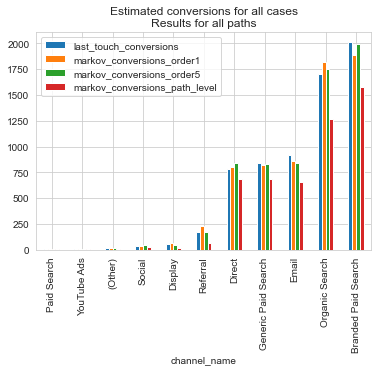

In [78]:
# plot results 
results_all_models.sort_values('last_touch_conversions').plot(x = 'channel_name', y = ['last_touch_conversions', 'markov_conversions_order1', 'markov_conversions_order5', 'markov_conversions_path_level'], kind = 'bar')
plt.title('Estimated conversions for all cases\nResults for all paths')
plt.show()

#### New paths attribution 

Function that uses removal effects and corrective factors (?) from markov_model_local() to calculate weights for channels belonging to new paths. Used in **real time attribution**. It saves the parameters extracted from mar_model() and applies it to new data in real-time. 

(!) This is not that interesting to us, because visits are not as frequent as they can be in e-commerce. 

In [79]:
# mm_paths_attribution = CAP.new_paths_attribution() or CAP.new_paths_attribution_odds()

### About validation of Markov Chains 

From Channel Attribution white paper: 

"Why Markov model is a global approach? Markov model aggregates real paths to build a Markov graph, a
graphical representation of a transition matrix. Markov graph is a mathematical representation of the dynamics
between channels. Markov model generates millions of random paths from Markov graph. Random paths are
used to calculate importance weights (removal effects) for each channel. At the end of the process importance
weights are normalized and multiplied by total conversions (the overall conversions observed for all the paths
considered) to make attribution for each channel. Thus Makov model is global because first it aggregates paths
to build transition matrix and then it works with simulate paths forgetting each single real path." 

Two functions exist for transaction-level attribution: `markov_model_local(), new_paths_attribution()`. 

**Package ChannelAttributionPro does not let us validate the models, either. Just get attribution for new paths (i.e. real-time attribution), based on parameters of the already modelled markov-chain**

## Modelling trial III: ML approach (XGBoost)

It tries to classify a path as being successful (conversion) or not (no-conversion), using all available features 

### Feature engineering - extracted from Wang 2019

* Standard, tabular format, which contains the important predictive information encoded into features 
* *Marketing channel count vectors*: One feature per each marketing channel. Value is the total number of times a visit from that channel occurred in the customer journey. Order of visits is not considered, because an exponential number of features would be needed. 
* *Number of visits*: touchpoint number, i.e. number of visits a journey contains 
* *Number of unique marketing channels* - number of non-zero values in each row of marketing channel count vectors  
* Features related to level of engagement: *visit duration, number of pages browsed, number of pages viewed*. Sum accross all visits (path)

Created features are then compared with conversion rate to see if predicted power is expected. 

In [80]:
# create dataset to work with (df_ml)
df_ml = df_merge[['clientID', 'path_counter', 'Operating system', 'Transactions', 'Total time on site', 'Pageviews', 'general_type_of_client', 'touchpoints_number']]
df_ml = df_ml.groupby(['clientID', 'path_counter', 'Operating system', 'general_type_of_client', 'touchpoints_number']).sum().reset_index()
# create Marketing channel count vectors - one feature per each marketing channel, with total times of visits per channel 
df_count_vectors = df_merge[['clientID', 'Channel group', 'path_counter']]

## pivot table 
df_count_vectors = pd.get_dummies(df_count_vectors, columns = ['Channel group']).groupby(['clientID', 'path_counter']).sum().reset_index()

# number of visits = touchpoints_number 
# number of unique marketing channels 
df_count_vectors['unique_marketing_channels'] = df_count_vectors.astype(bool).sum(axis = 1) - 2

# merge 
df_ml = pd.merge(left = df_count_vectors, right = df_ml, on = ['clientID', 'path_counter'], how = 'left')
# create output variable from Transactions (1/0)
df_ml['Transactions'] = np.where(df_ml['Transactions'] > 1, 1, df_ml['Transactions'])
# df_ml['Transactions'].value_counts() # check 
df_ml

,clientID,path_counter,Channel group_(Other),Channel group_Branded Paid Search,Channel group_Direct,Channel group_Display,Channel group_Email,Channel group_Generic Paid Search,Channel group_Organic Search,Channel group_Paid Search,Channel group_Referral,Channel group_Social,Channel group_YouTube Ads,unique_marketing_channels,Operating system,general_type_of_client,touchpoints_number,Transactions,Total time on site,Pageviews
0,1000005671.1568444004,1,0,0,0,1,0,0,0,0,0,0,0,1,Android,new_in_2021,1,0,0,1
1,1000006728.1622927843,1,0,0,1,0,0,0,0,0,0,0,0,1,iOS,new_in_2021,1,0,0,1
2,1000020259.1556972396,1,0,0,0,0,0,0,0,0,1,0,0,1,Android,new_in_2021,1,0,0,1
3,1000024791.1630470945,1,0,1,0,0,0,0,0,0,0,0,0,1,iOS,new_in_2021,1,0,38,2
4,1000025674.1610314739,1,0,0,0,0,0,0,1,0,0,0,0,1,Windows,new_in_2021,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330582,999973068.1611254848,1,0,0,0,1,0,0,0,0,0,0,0,1,Android,new_in_2021,1,0,0,1
330583,99997309.1608586309,1,0,0,0,1,0,0,0,0,0,0,0,1,Android,new_in_2021,1,0,0,1
330584,999988377.1636720143,1,0,0,0,1,0,0,0,0,0,0,0,1,Windows,new_in_2021,1,0,0,1
330585,999996741.1623865085,1,1,0,0,0,0,0,0,0,0,0,0,1,Android,new_in_2021,1,0,0,1


(!) Important! Apparently, XGBoost does not accept categorical data, so one-hot encoding is necessary

https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390

(?) Wouldnt it be better to group minority categories into "other"? 

In [81]:
# check correlation between Transactions (output) and all other features 
X = df_ml

# one-hot encoding for categorical (object) features 
encoder = OneHotEncoder(sparse = False)
X_encoded = pd.DataFrame(encoder.fit_transform(X[['Operating system', 'general_type_of_client']]))
X_encoded.columns = encoder.get_feature_names(['Operating system', 'general_type_of_client'])
X.drop(['Operating system', 'general_type_of_client'], axis = 1, inplace = True)
X = pd.concat([X, X_encoded], axis = 1)

<AxesSubplot:>

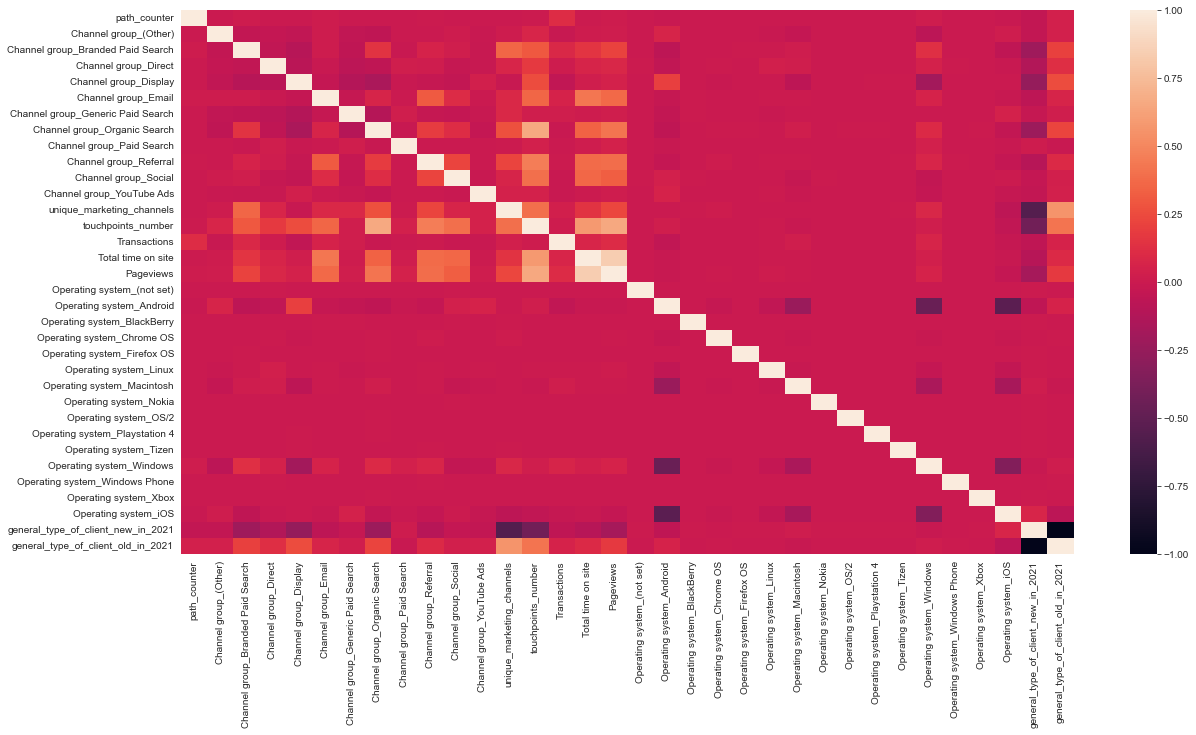

In [82]:
# create heatmap (correlogram) of output vs rest 
# https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e 
plt.figure(figsize=(20, 10))
sns.heatmap(X.corr()) # [['Transactions']]

In [83]:
X.corr()[['Transactions']]

,Transactions
path_counter,0.114450
Channel group_(Other),-0.018147
Channel group_Branded Paid Search,0.088390
Channel group_Direct,0.012657
Channel group_Display,-0.049364
Channel group_Email,0.061139
Channel group_Generic Paid Search,0.027365
Channel group_Organic Search,-0.013417
Channel group_Paid Search,-0.005150
Channel group_Referral,0.005186


<AxesSubplot:>

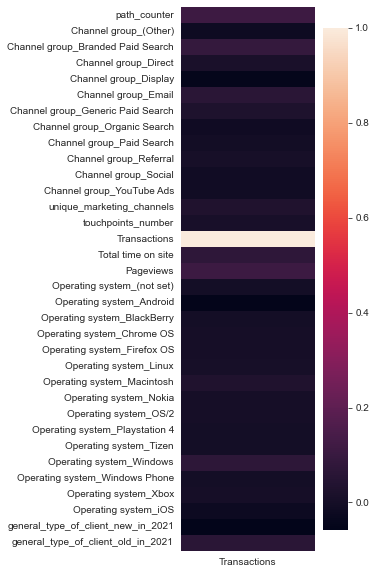

In [84]:
# focus: Transactions 
plt.figure(figsize=(3, 10))
sns.heatmap(X.corr()[['Transactions']]) 

In [85]:
# divide table into X, y 
X = X.drop('Transactions', axis = 1)
y = df_ml.Transactions

# split paths into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 25)
print(f"No. of training examples: {X_train.shape[0]}")
print(f"No. of testing examples: {X_test.shape[0]}")

# extract clientID and drop it from dataset to model with 
X_train_clientID = X_train['clientID']
X_test_clientID = X_test['clientID']
X_train.drop(labels = 'clientID', axis = 1, inplace = True)
X_test.drop(labels = 'clientID', axis = 1, inplace = True)

# check that percentage of transactions remain stable 
# print(y_train.value_counts()) 
# print(y_test.value_counts())

No. of training examples: 264469
No. of testing examples: 66118


### Baseline model

- Standard parameter values 

In [86]:
def cm_heatmap (pred_label, test_output = y_test):    
    # create confusion matrix and heatmap with it 
    cm = confusion_matrix(y_true = test_output, y_pred = pred_label)
    # print('Confusion matrix')
    # print(cm) 
    ax = sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = 'g', xticklabels = True, yticklabels = True)
    ax.set_title('Confusion matrix')
    ax.set_ylabel('Actual values')
    ax.set_xlabel('Predicted values')
    plt.show()

    return cm

In [87]:
# function to extract metrics from confusion matrix. Extracted from https://towardsdatascience.com/evaluating-machine-learning-classification-problems-in-python-5-1-metrics-that-matter-792c6faddf5 
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    
    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy
    
    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))
    
    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')

In [88]:
def auc_roc (pred_label, test_output = y_test): 
    fpr, tpr, thresholds = roc_curve(test_output, pred_label, pos_label = 1)
    auc = roc_auc_score(test_output, pred_label)
    auc = round(auc, 4)
    # message = print('AUC: %.3f' % auc)
    # plot the roc curve for the model
    plt.plot(fpr, tpr, linestyle='--', label= f'AUC {auc}') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for XGBoost')
    plt.legend()
    plt.show()

In [89]:
# function to model and get results, for different cases 
def pred_labels (model, # instantiate model 
                 train_data = X_train, 
                 train_output = y_train, 
                 test_data = X_test, 
                 test_output = y_test):
    
    # fit and predict
    model.fit(train_data, train_output)
    pred_probs = model.predict_proba(test_data) # probs
    pred_label = model.predict(test_data) # labels 0/1
    return pred_label

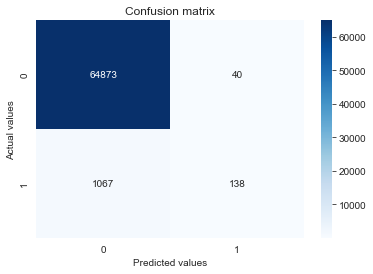

True Positives: 138
True Negatives: 64873
False Positives: 40
False Negatives: 1067
--------------------------------------------------
Accuracy: 0.98
Mis-Classification: 0.02
Sensitivity: 0.11
Specificity: 1.0
Precision: 1.0
f_1 Score: 0.21


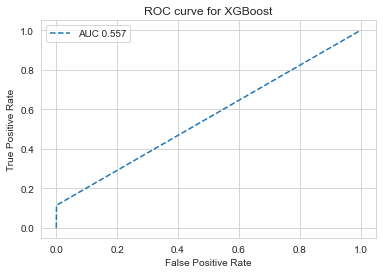

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

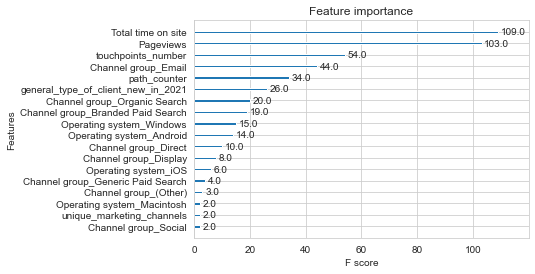

In [90]:
# instantiate model and extract predicted labels 
m_xgb = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators = 10, scale_pos_weight = 1, seed = 25)
m_xgb_pred_label = pred_labels(model = m_xgb)

# Heatmap of confusion matrix 
cm = cm_heatmap(pred_label = m_xgb_pred_label)
confusion_metrics(cm)
auc_roc(pred_label = m_xgb_pred_label)

plot_importance(m_xgb)

### Model with class weight argument

#### Use weighted class to improve imbalance

see https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

- Use `scale_pos_weight` hyperparameter, which is used to scale the gradient for the positive class. 
- The gradient refers to the steepness of the loss function (i.e. the amount of error). A small gradients means a small error and in turn, a small change to the model to correct the error. A large gradient results in a large correction to the model

In [91]:
# extract estimated to use as argument at model 

# count examples in each class
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 53.858


Function `predict` predicts labels (0/1). Function `predict_proba` predicts probabilities for negative and positive classes. In both cases, and to get probabilities between 0 and 1, we need to use 'binary:logistic' as objective.

As we can see, results are now way better. 

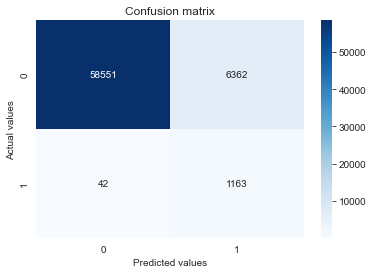

True Positives: 1163
True Negatives: 58551
False Positives: 6362
False Negatives: 42
--------------------------------------------------
Accuracy: 0.9
Mis-Classification: 0.1
Sensitivity: 0.97
Specificity: 0.9
Precision: 0.9
f_1 Score: 0.93


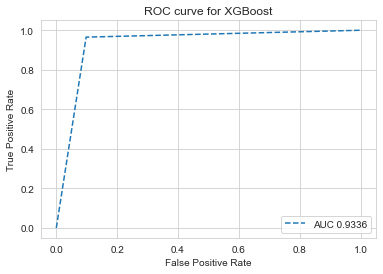

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

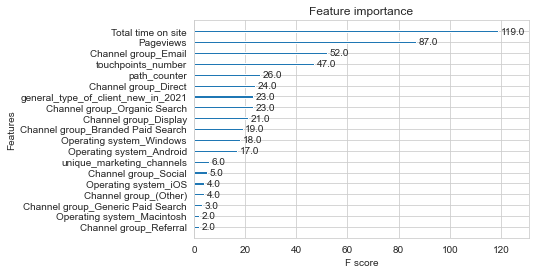

In [92]:
# instantiate model and extract predicted labels 
m_xgb_weight = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators = 10, scale_pos_weight = estimate, seed = 25, eval_metric = 'auc')
m_xgb_weight_pred_label = pred_labels(model = m_xgb_weight)

# Heatmap of confusion matrix 
cm = cm_heatmap(pred_label = m_xgb_weight_pred_label)
confusion_metrics(cm)
auc_roc(pred_label = m_xgb_weight_pred_label)

plot_importance(m_xgb_weight)

In [93]:
# extract used set of hyperparameters 
m_xgb_weight


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=25,
              reg_alpha=0, reg_lambda=1, ...)

In [94]:
# tune class weighting hyperparameter 

# define grid
#weights = [1, 10, 25, 50, 75, 99, 100, 1000]
#param_grid = dict(scale_pos_weight=weights)

# define evaluation procedure
#from sklearn.model_selection import GridSearchCV
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
#grid = GridSearchCV(estimator= m_xgb_weight, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
#grid_result = grid.fit(X_train, y_train)
# report the best configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Best: 0.972921 using {'scale_pos_weight': 10}

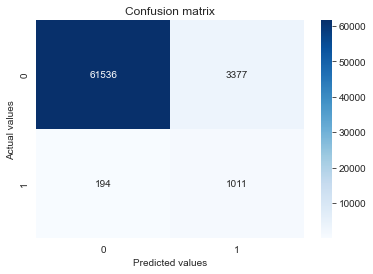

True Positives: 1011
True Negatives: 61536
False Positives: 3377
False Negatives: 194
--------------------------------------------------
Accuracy: 0.95
Mis-Classification: 0.05
Sensitivity: 0.84
Specificity: 0.95
Precision: 0.95
f_1 Score: 0.89


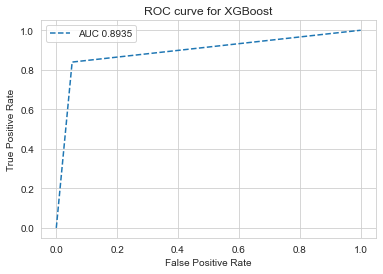

In [95]:
# re-fit model with estimate extracted from GridSearchCV  
estimate2 = 10
m_xgb_weight2 = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators = 10, scale_pos_weight = estimate2, seed = 25, eval_metric = 'auc')
m_xgb_weight2_pred_label = pred_labels(model = m_xgb_weight2)

# Heatmap of confusion matrix 
cm = cm_heatmap(pred_label = m_xgb_weight2_pred_label)
confusion_metrics(cm)
auc_roc(pred_label = m_xgb_weight2_pred_label)

#plot_importance(m_xgb_weight2)

#### Model with hyperparameter tuning using GridSearchCV

Results are actually already very good, but we can still try to do some hyperparameter tuning and try to improve them. 

See https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663 

Results obtained by grid search are actually not better than those obtains by just using the "estimate" 

In [96]:
from sklearn.model_selection import GridSearchCV
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.1, 0.3],
           'n_estimators': [10, 100],
           'colsample_bytree': [0.3, 1]}

# check possible values for 'scoring' argument in GridSearchCV 
# from sklearn.metrics import get_scorer_names
# get_scorer_names()
# clf = GridSearchCV(estimator = m_xgb_weight, 
#                   param_grid = params,
#                   scoring= 'roc_auc', 
#                   verbose=1)
# clf.fit(X_train, y_train) # takes 41 mins 
# print("Best parameters:", clf.best_params_)
# Best parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


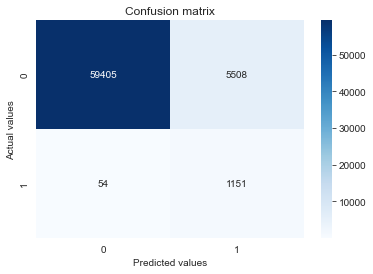

True Positives: 1151
True Negatives: 59405
False Positives: 5508
False Negatives: 54
--------------------------------------------------
Accuracy: 0.92
Mis-Classification: 0.08
Sensitivity: 0.96
Specificity: 0.92
Precision: 0.92
f_1 Score: 0.93


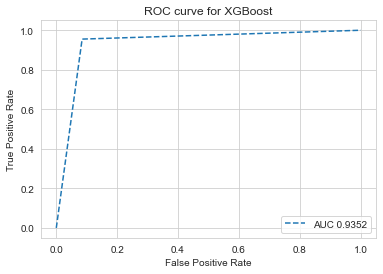

In [98]:
# use best parameters and class weight 
m_xgb_grid_weight = xgb.XGBClassifier(objective = 'binary:logistic', 
                                      seed = 25, 
                                      learning_rate = 0.1, 
                                      n_estimators = 100, 
                                      max_depth = 6, 
                                      colsample_bytree = 1, 
                                      eval_metric = 'auc',
                                      scale_pos_weight = estimate) 
m_xgb_grid_weight_pred_label = pred_labels(model = m_xgb_grid_weight)

# Heatmap of confusion matrix 
cm = cm_heatmap(pred_label = m_xgb_grid_weight_pred_label)
confusion_metrics(cm)
auc_roc(pred_label = m_xgb_grid_weight_pred_label)

#plot_importance(m_xgb_weight2)


Feature importance scores can be used for feaure selection using SelectFromModel, see https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
However, I am not sure how does that affect the model, because most of our features are one-hot encodings of original features.
Here https://www.listendata.com/2016/07/insignificant-levels-of-categorical-variable.html it is indicated tha we can just include or exclude whole variables, i.e. we cannot just exclude some categories that are not important for modelling. 

#### Info about data leakage in model 

- Features like *time on site* and *pageviews* are the most important 
    - This gives us important information about the behavior of the donors on the website 
    - However, this information can just be integrated if using a model that works on a real-time basis 
- On the other hand, to totally avoid data leakage from the model we should just take into account the information of touchpoints PREVIOUS to the conversion. In our case, this means getting rid of 75% of the data 
- In other words, model is just to be used as an informative tool of most important features. Eventually, a real-life setting could be applied. Model could also be trained on a dataset treated differently